# Libraries

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from omegaconf import OmegaConf
from src.models import models
from src.models import model as mainmodel
from src.models import modelConv2d
from src.models import modelineal
from src.models import decoders
from src import loss_func
from src import train
from src import loader
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from src import optimizer_Factory as of
import Data.genData as genData
from src import custom_plots as cp
from src import Visual_utils as vu
import torchvision
import wandb
import random
import os


os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:2000"
torch.cuda.empty_cache() 
torch.manual_seed(42)

## Generate images paper

/Users/alejandro/Documents/Phd/Repositories/Own/Vphy/Figures/figures_exp.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

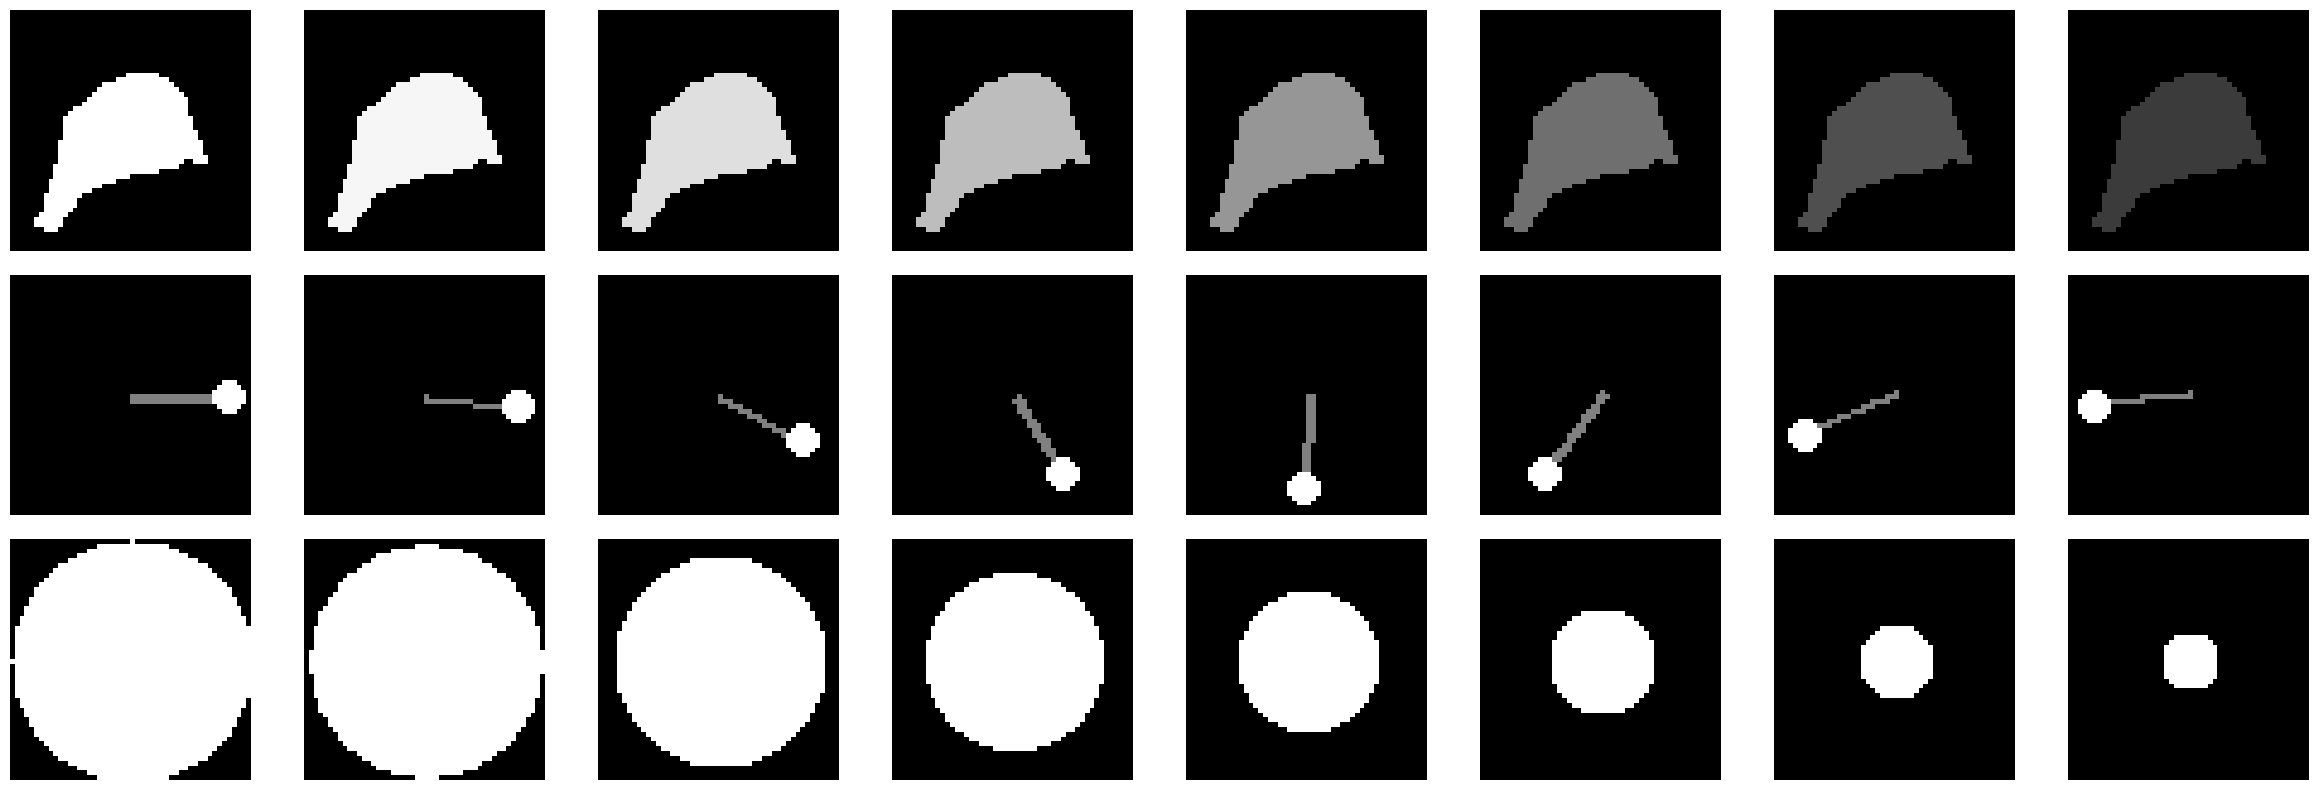

In [23]:
from Figures import figures_exp, init_exp

figures_exp.main()

Using device: cuda
Initial Loss 	 training loss: 5.378703905020648 	 validation loss: 6.136858487129212
epoch: 5 	 training loss: 0.4198087007410613 	 validation loss: 2.080535246928533
epoch: 10 	 training loss: 0.12506757186431633 	 validation loss: 1.6135355333487194
epoch: 15 	 training loss: 0.10640650539685358 	 validation loss: 1.7415442764759064
epoch: 20 	 training loss: 0.1190510401539957 	 validation loss: 1.81280819773674
epoch: 25 	 training loss: 0.12128389193129684 	 validation loss: 1.8866485317548116
epoch: 30 	 training loss: 0.10031959824716515 	 validation loss: 1.8323942005634308
epoch: 35 	 training loss: 0.10247291563086303 	 validation loss: 1.7378552675247192
epoch: 40 	 training loss: 0.09367011298203035 	 validation loss: 1.6205008467038473
epoch: 45 	 training loss: 0.08820226657306135 	 validation loss: 1.8394621511300404
epoch: 50 	 training loss: 0.09312707591832046 	 validation loss: 1.8016035815080007
Using device: cuda
Initial Loss 	 training loss: 5.5

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch: 50 	 training loss: 0.11352171429889163 	 validation loss: 1.8573622584342957


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

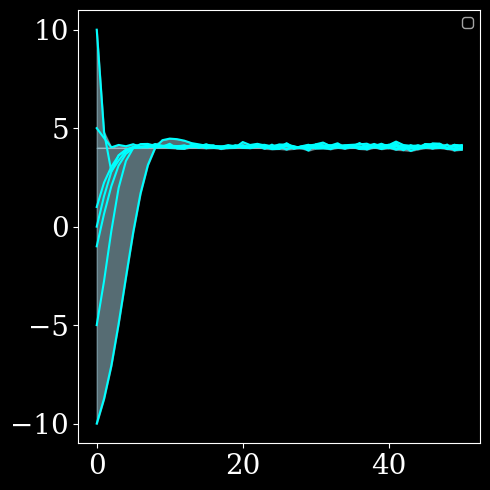

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


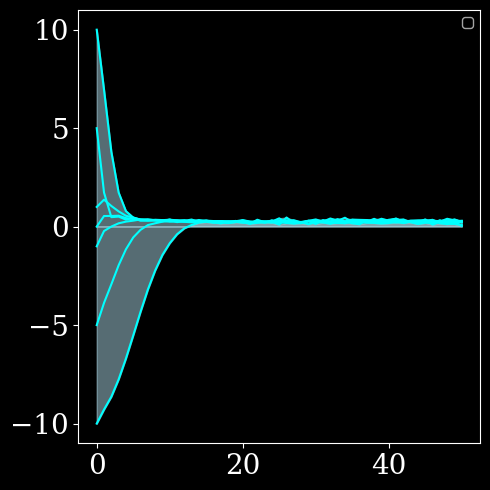

Best alpha:  4.046096324920654
Best beta:  0.2027599119714328
Best alpha std:  0.07576850825612118
Best beta std:  0.09337798085301163


In [7]:
from Figures import figures_exp, init_exp
init_exp.main()

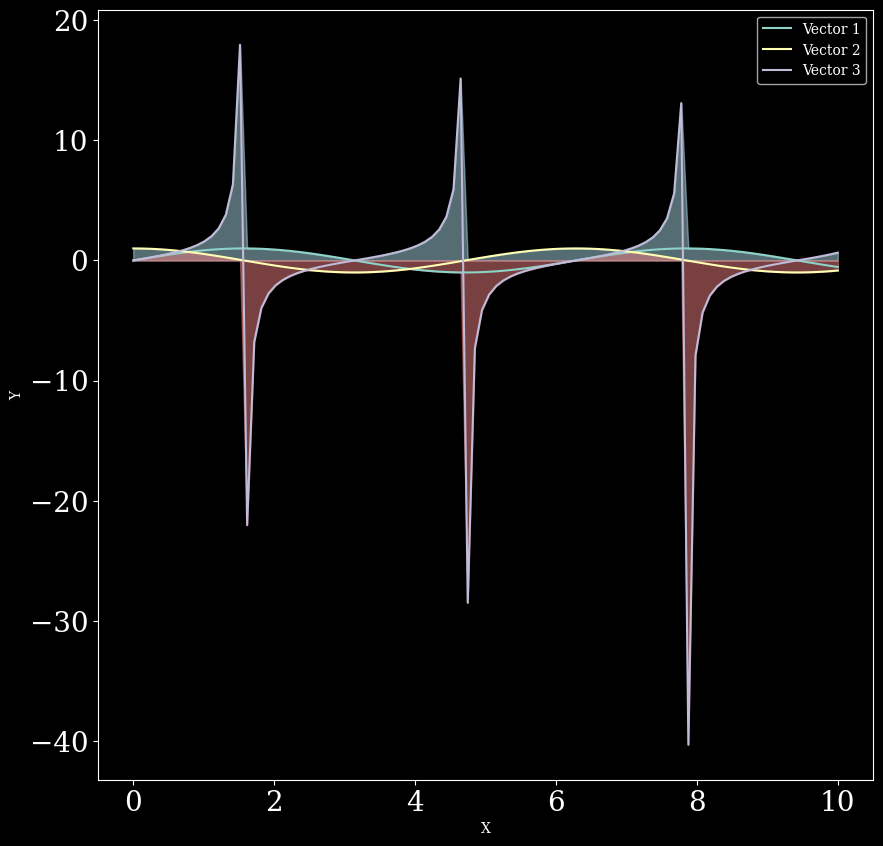

In [58]:
import numpy as np
import matplotlib.pyplot as plt

# Example data - multiple vectors
x = np.linspace(0, 10, 100)
y1 = np.sin(x)
y2 = np.cos(x)
y3 = np.tan(x)

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 10))

# Plot all vectors
ax.plot(x, y1, label='Vector 1')
ax.plot(x, y2, label='Vector 2')
ax.plot(x, y3, label='Vector 3')

# Find the maximum value and its index among all vectors
max_values = np.max([y1, y2, y3], axis=0)
min_values = np.min([y1, y2, y3], axis=0)


# Fill the area under the curve of the maximum value vector and under zero
ax.fill_between(x, 0, max_values,  color='lightblue', alpha=0.5)
ax.fill_between(x, min_values, 0,  color='lightcoral', alpha=0.5)

# Add legend and labels
ax.legend()
ax.set_xlabel('X')
ax.set_ylabel('Y')

# Show the plot
plt.show()

## Numerical Model

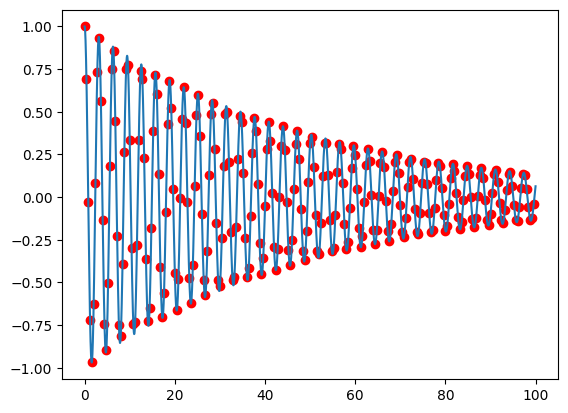

0.05


In [27]:
t = np.arange(0,100, 1/100)

y = np.exp(-0.02*t)*np.cos(2*t)
#np.exp(-0.1*t)*
t_s = t[0::40]

y_s = y[0::40]

plt.plot(t, y)
plt.scatter(t_s, y_s,c='r')

plt.show()

print(t[5]-t[0])

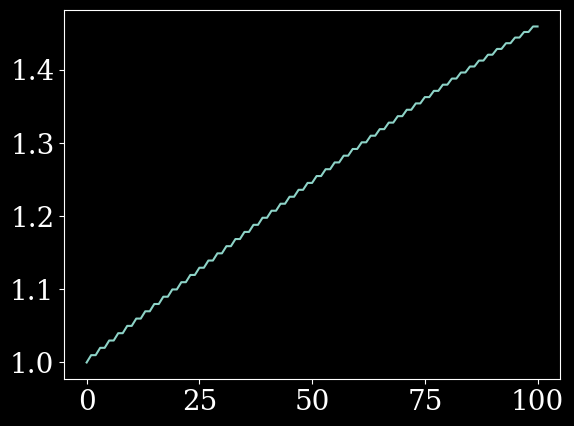

In [66]:
y = []
y_1 = []
y_2 = []

def y_3(y,y_1,y_2):
    return -1*y_1 -1*y

y.append(1)
y_1.append(1)
y_2.append(0)
dt = 0.01
for i in range(100):

    y.append(y[i-1] + y_1[i-1]*dt )
    y_1.append(y_1[i-1] + y_2[i-1]*dt )
    y_2.append( y_2[i-1] + y_3( y[i-1],y_1[i-1],y_2[i-1]   )*dt )


y = np.array(y)
x = np.arange(0,101,1)

plt.plot(x,y)
plt.show()


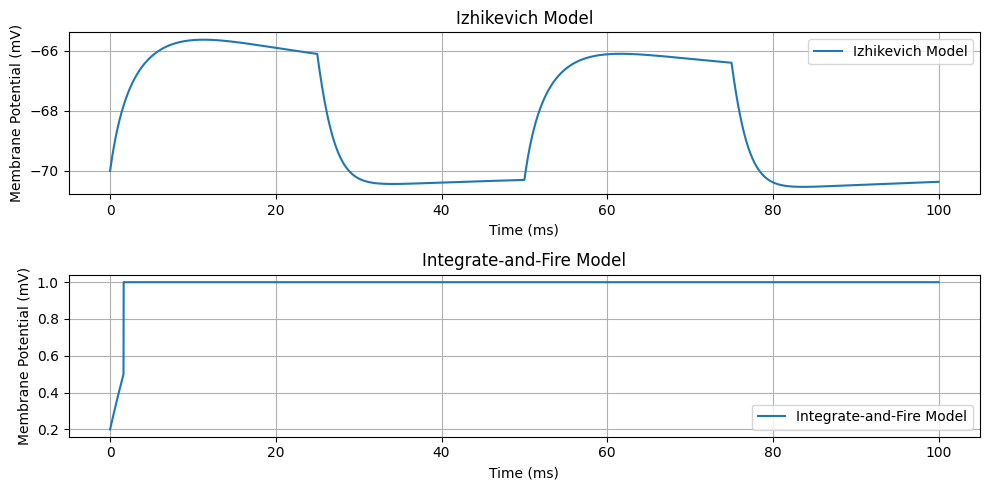

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the Izhikevich model
a = 0.02
b = 0.2
c = -65
d = 8

# Parameters for the integrate-and-fire model
tau_m = 10  # Membrane time constant (ms)
V_rest = -65  # Resting membrane potential (mV)
V_th = -50  # Threshold potential (mV)
V_reset = 0.2  # Reset potential after spike (mV)
R = 1  # Membrane resistance (Ohm)
I = 2  # Applied current (nA)

# Simulation parameters
dt = 0.01  # Time step (ms)
t_max = 100  # Total simulation time (ms)
num_steps = int(t_max / dt)  # Number of simulation steps



# Initialize variables for Izhikevich model
v = -70  # Initial membrane potential (mV)
u = b * v  # Initial recovery variable

# Initialize variables for integrate-and-fire model
v_IF = V_rest  # Initial membrane potential (mV)

# Arrays to store simulation results
time = np.arange(0, t_max, dt)
I = np.sin(2 * np.pi * time / 50)  # Sinusoidal input current
I[I < 0] = 0  # Half-wave rectification
I[I > 0] = 2  # Double the current for positive values
v_izhikevich = np.zeros_like(time)
v_integrate_fire = np.zeros_like(time)

# Simulation loop
for i in range(num_steps):
    # Izhikevich model dynamics
    dv = (0.04 * v ** 2 + 5 * v + 140 - u + I[i]) * dt
    du = (a * (b * v - u)) * dt
    v += dv
    u += du
    if v >= 30:
        v = c
        u += d

    # Integrate-and-fire model dynamics
    dv_IF = (V_rest - v_IF + R * I[i]) / tau_m * dt
    v_IF += dv_IF
    if v_IF >= V_th:
        v_IF = V_reset

    # Store membrane potentials
    v_izhikevich[i] = v
    v_integrate_fire[i] = v_IF

# Plotting results
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(time, v_izhikevich, label='Izhikevich Model')
plt.title('Izhikevich Model')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(time, v_integrate_fire, label='Integrate-and-Fire Model')
plt.title('Integrate-and-Fire Model')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

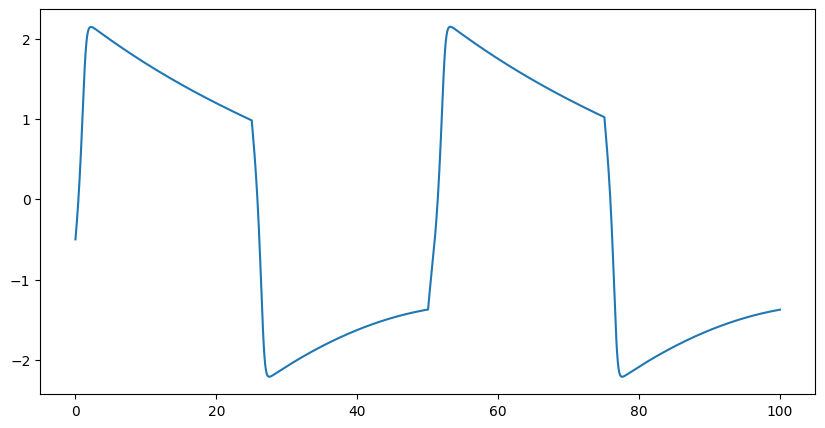

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# FitzHugh-Nagumo Model parameters
a = 0.7
epsilon = 0.08
I_amp = 1  # Amplitude of input current
I_freq = 20  # Frequency of input current (Hz)

# Input current function (pulse train)
def input_current(t):

    I = I_amp * (1 + np.sin(2 * np.pi * I_freq * t)) / 2

    I = 0 if I < 0.5 else 1
    return I


# Euler method for solving differential equations
def euler(f, y0, t):
    dt = t[1] - t[0]
    y = np.zeros((len(t), len(y0)))
    y[0] = y0
    for i in range(1, len(t)):
        y[i] = y[i - 1] + f(t[i - 1], y[i - 1]) * dt
    return y

# FitzHugh-Nagumo model equations
def fitzhugh_nagumo(t, y):
    v, w = y
    dvdt = v - (v ** 3) / 3 - w + input_current(t)
    dwdt = epsilon * (v + a - w)
    return np.array([dvdt, dwdt])

# Simulation parameters
t_start = 0
t_end = 100
num_points = 1000
t = np.linspace(t_start, t_end, num_points)

# Initial conditions
v0 = -0.5
w0 = -0.5
y0 = np.array([v0, w0])

# Solve the differential equations using Euler method
sol = euler(fitzhugh_nagumo, y0, t)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(t, sol[:, 0], label='Membrane Potential (v)')
plt.plot(t, input_current(t), label='Input Current (I)')
plt.title('FitzHugh-Nagumo Model with Pulse Train Input Current (Euler Method)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


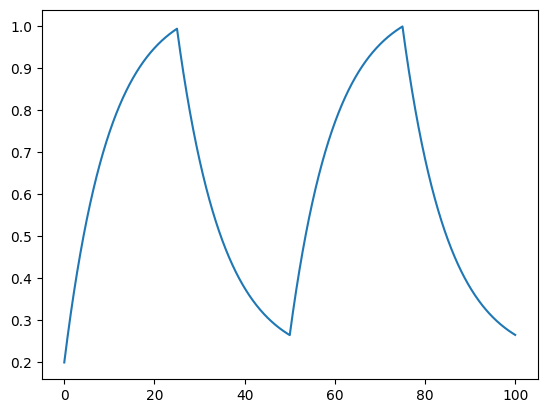

In [39]:
t,a = genData.generateIntegrated_Fire_model()

plt.plot(t,a)
plt.show()

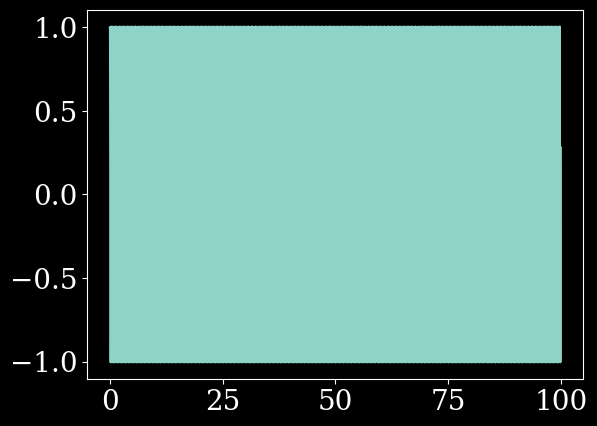

In [ ]:
y_list =[]

y0 = y[0]
y1 = y[1]

y_list.append(y0)
y_list.append(y1)

dt = 0.1*1

for i in range(2, len(t)):
    
    y2 = y1 +(y1 - y0) - dt*(0.0*(y1-y0) +dt*4*y1)

    y_list.append(y2)
    y0 = y1
    y1 = y2
    

y_list = np.array(y_list)

plt.plot(t, y_list)
plt.show()

# Pendulum

### Load Data

In [10]:
t,a = genData.generateDynamics(1,(-1))
train_dataloader, test_dataloader, train_x, val_x  = loader.getLoader(a,type="Motion")

<Figure size 640x480 with 0 Axes>

### Visualizations

In [70]:
genData.generateVideo(a,DynamicsType = "Motion", name = "Pendulum_Original_video")

Batch shape: torch.Size([32, 3, 50, 50])
torch.Size([3, 50, 50])
torch.Size([1, 50, 50])


C:\Users\aleja\AppData\Local\Temp\ipykernel_18784\296776735.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Greys_r', 256)
C:\Users\aleja\AppData\Local\Temp\ipykernel_18784\296776735.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Greys_r', 256)


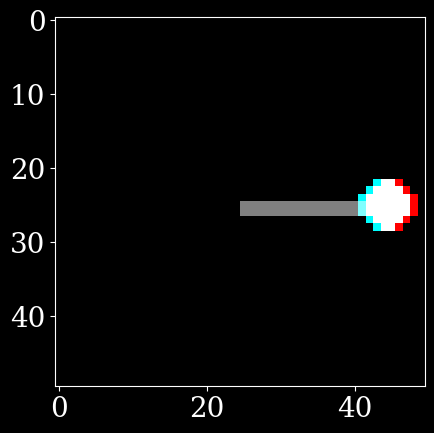

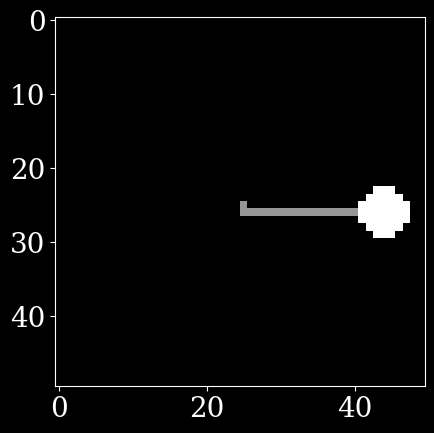

In [71]:
train_dataloader, test_dataloader, train_x, val_x  = loader.getLoader(a, type="Motion")

data_iter = iter(train_dataloader)

# Get a batch of data
batch_data = next(data_iter)


# Get the shape of the batch
batch_shape = batch_data[0].shape

print("Batch shape:", batch_shape)

testimage = batch_data[0][0,:,:,:]
cmap = plt.cm.get_cmap('Greys_r', 256)

print(testimage.shape)

# set gray colormap imshow
plt.figure()
plt.imshow(testimage.permute(1, 2, 0), cmap=cmap, interpolation='nearest')

testimage = batch_data[1][0,:,:,:]
cmap = plt.cm.get_cmap('Greys_r', 256)

print(testimage.shape)

# set gray colormap imshow
plt.figure()
plt.imshow(testimage.permute(1, 2, 0), cmap=cmap, interpolation='nearest')


### Model 

In [11]:

#train_dataloader, test_dataloader, train_x, val_x  = loader.getLoader(a)
modelAE = models.AE(dt=1/30, initw=True)
modelAE, train_losses, val_losses, accuracy_list  = train.train(modelAE, train_dataloader, test_dataloader, 'GNNSimple')

IndexError: list index out of range

In [13]:
visual_loader= loader.getLoader(a, type="Motion", split=False)
vu.visualize(modelAE, visual_loader, video_name = 'Conv2d_ExpVsPred.mp4')
vu.CompareLatent(modelAE, visual_loader)

NameError: name 'modelAE' is not defined

### Test Decoder

In [6]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:2000"
torch.cuda.empty_cache() 
torch.manual_seed(42)

train_dataloader, test_dataloader, train_x, val_x  = loader.getLoader_decoder(a, type = "Motion")
linearDecoder = decoders.convDecoder(initw=True)
linearDecoder, train_losses, val_losses, accuracy_list  = train.train(linearDecoder, train_dataloader, test_dataloader, '../Results/Motion_Decoder', loss_name='decoder_loss')

Using device: cpu


wandb: ERROR Control-C detected -- Run data was not synced


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


In [5]:
visual_loader= loader.getLoader_decoder(a, split=False, type = "Motion")
vu.visualize_dec(linearDecoder, visual_loader, video_name = './Results/Motion_Decoder_ExpVsPred.mp4')

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


Video saved as ./Results/Motion_Decoder_ExpVsPred.mp4


### Test Encoder Phys

In [68]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:2000"
torch.cuda.empty_cache() 
torch.manual_seed(42)

t,a = genData.generateDynamics(max=0.5, min = -0.5)
sr = 10
dt_sim = t[1]-t[0]
print("dt_sim", dt_sim)
dt = dt_sim*sr
train_dataloader, test_dataloader, train_x, val_x  = loader.getLoader(a,type="Motion", split = True,  dt=dt_sim, nInFrames = 5,sr = sr ,  noise=False, shapeType='simple')
latentEncoder = mainmodel.EndPhys(dt = dt,pmodel = "Damped_oscillation", initw=True)
latentEncoder, logs = train.train(latentEncoder, train_dataloader, test_dataloader,  loss_name='latent_loss')

dt_sim 0.01
Using device: cpu


Initial Loss 	 training loss: 6.016430211445642 	 validation loss: 5.501525431871414


alpha,▁▂▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇▇██████
beta,▁▇██████████▇▇▇▇▇▇▇▇▆▆▆▆▆
train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,█▁▁▁▂▁▂▁▁▂▁▂▂▂▂▂▁▂▂▂▂▁▂▂▂
alpha,4.49713
beta,0.91353
train_loss,0.03962
validation_loss,1.53669


[{'train_loss': 6.016430211445642, 'validation_loss': 5.501525431871414, 'alpha': array(4.497129, dtype=float32), 'beta': array(0.9135313, dtype=float32)}, {'train_loss': 0.960895368770238, 'validation_loss': 1.0549062937498093, 'alpha': 1.202728033065796, 'beta': 1.0760949850082397}, {'train_loss': 0.04674976018981801, 'validation_loss': 1.0327149219810963, 'alpha': 1.4270803928375244, 'beta': 1.1044938564300537}, {'train_loss': 0.038121792236490856, 'validation_loss': 1.1400583013892174, 'alpha': 1.6248934268951416, 'beta': 1.110305905342102}, {'train_loss': 0.055646724067628384, 'validation_loss': 1.3531923294067383, 'alpha': 1.8249826431274414, 'beta': 1.116823673248291}]
4.497129
4.497128963470459


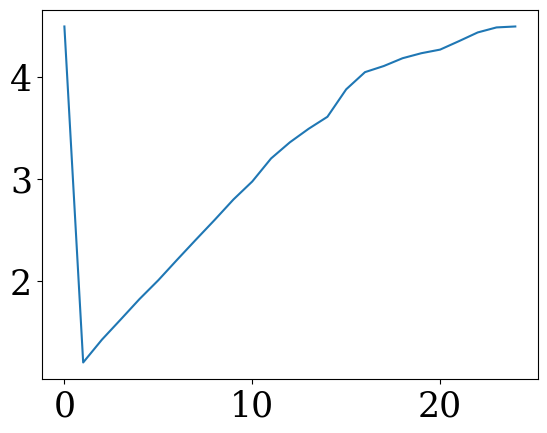

(2, 25)


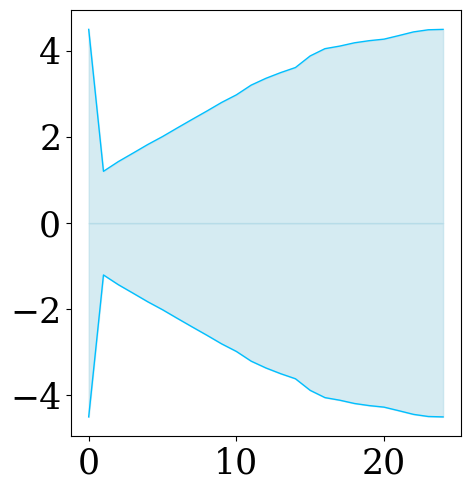

In [78]:
print(logs[0:5])

print(logs[0]["alpha"])

print(latentEncoder.pModel.alpha[0].detach().cpu().numpy().item())

key = "alpha"
a = [element[key] for element in logs  ]

plt.plot(a)
plt.show()

a = np.array(a)
b = [a , -a]

b = np.array(b)

print(b.shape)
cp.plotAreas(b, parameter_name="alpha")

In [44]:
sr = 20
visual_loader= loader.getLoader(a,type="Motion", split = False,   dt=1/100, nInFrames = 5,sr = sr ,  noise=False, shapeType='simple')
#vu.CompareLatent_end_phys(latentEncoder, visual_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


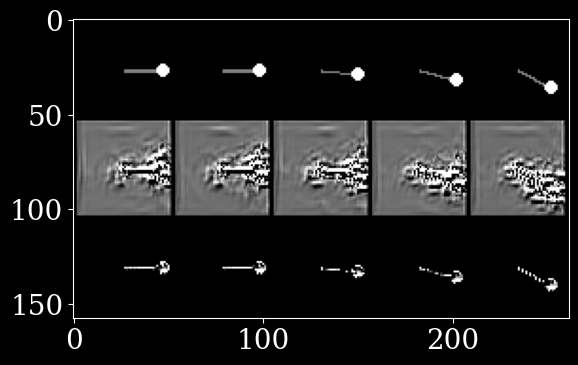

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


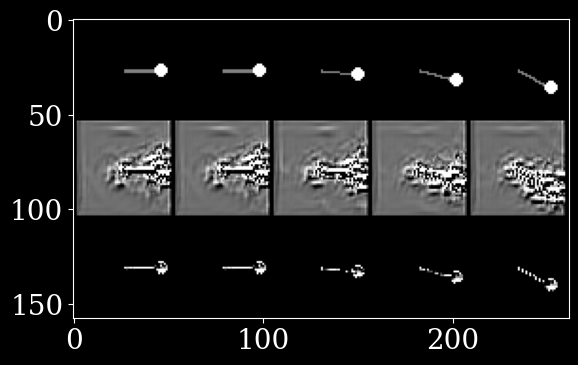

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


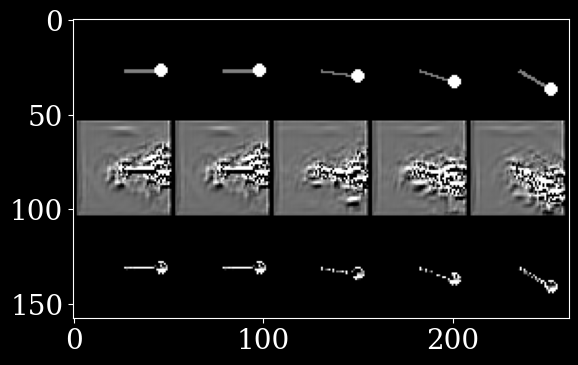

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


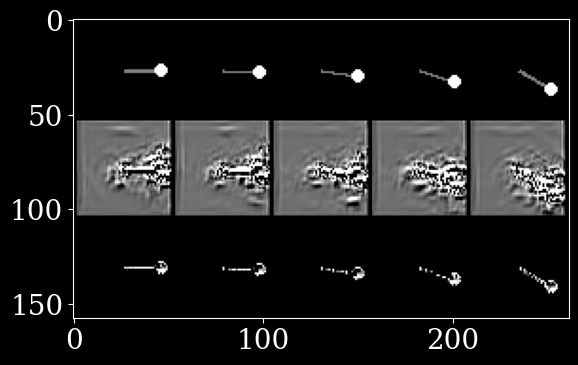

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


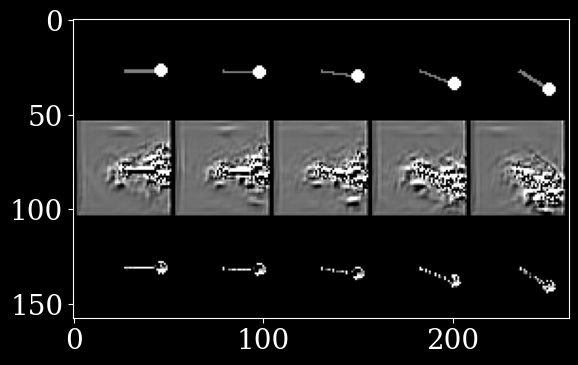

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


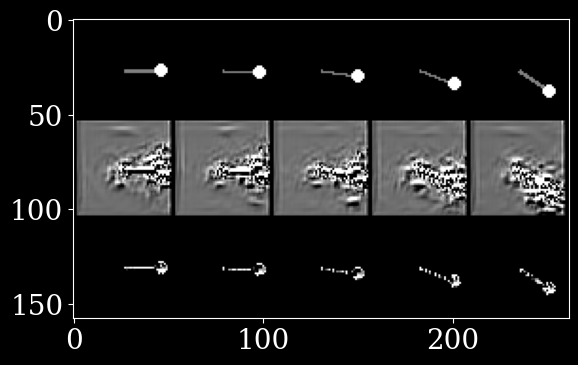

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


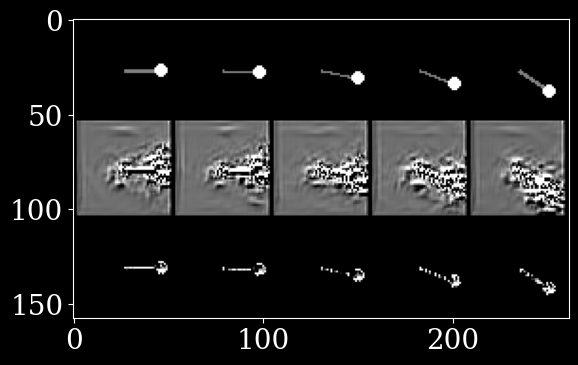

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


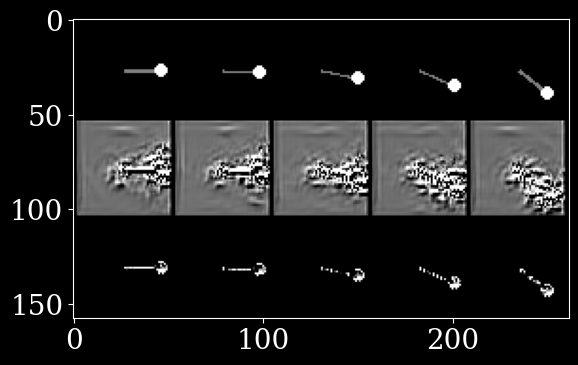

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


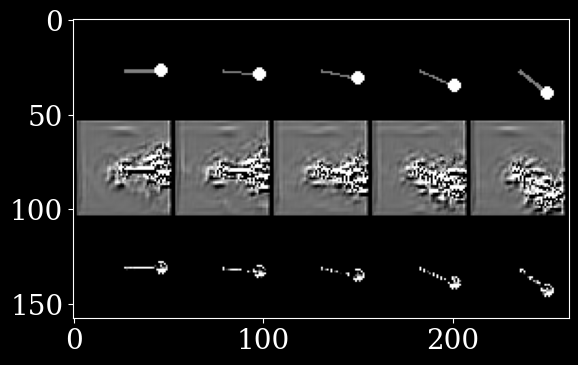

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


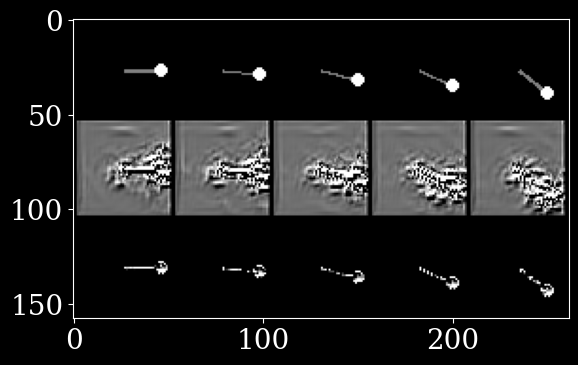

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


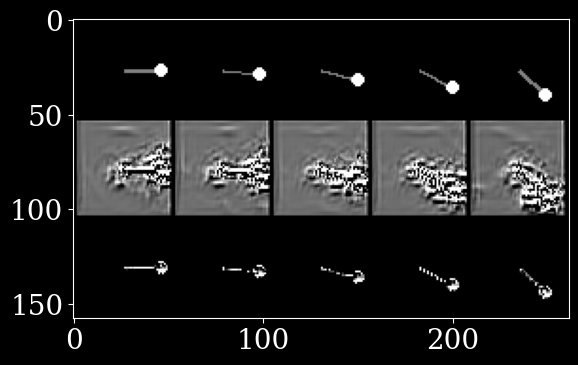

In [46]:
vu.view_masks(latentEncoder, visual_loader, iters = 10)

# double pendulum

In [5]:
#Get theta1 acceleration 
def theta1_acceleration(m1,m2,l1,l2,theta1,theta2,theta1_velocity,theta2_velocity,g):
    mass1 = -g*(2*m1 + m2)*np.sin(theta1)
    mass2 = -m2*g*np.sin(theta1 - 2*theta2)
    interaction = -2*np.sin(theta1 - theta2)*m2*np.cos(theta2_velocity**2*l2 + theta1_velocity**2*l1*np.cos(theta1 - theta2))
    normalization = l1*(2*m1 + m2 - m2*np.cos(2*theta1 - 2*theta2))
    
    theta1_ddot = (mass1 + mass2 + interaction)/normalization
    
    return theta1_ddot

#Get theta2 acceleration
def theta2_acceleration(m1,m2,l1,l2,theta1,theta2,theta1_velocity,theta2_velocity,g):
    system = 2*np.sin(theta1 - theta2)*(theta1_velocity**2*l1*(m1 + m2) + g*(m1 + m2)*np.cos(theta1) + theta2_velocity**2*l2*m2*np.cos(theta1 - theta2))
    normalization = l1*(2*m1 + m2 - m2*np.cos(2*theta1 - 2*theta2))
    
    theta2_ddot = system/normalization
    return theta2_ddot

#Update theta1
def theta1_update(m1,m2,l1,l2,theta1,theta2,theta1_velocity,theta2_velocity,g,time_step):
    #Numerical Integration
    theta1_velocity += time_step*theta1_acceleration(m1,m2,l1,l2,theta1,theta2,theta1_velocity,theta2_velocity,g)
    theta1 += time_step*theta1_velocity
    return theta1, theta1_velocity

#Update theta2
def theta2_update(m1,m2,l1,l2,theta1,theta2,theta1_velocity,theta2_velocity,g,time_step):
    #Numerical Integration
    theta2_velocity += time_step*theta2_acceleration(m1,m2,l1,l2,theta1,theta2,theta1_velocity,theta2_velocity,g)
    theta2 += time_step*theta2_velocity
    return theta2, theta2_velocity

#Run full double pendulum
def double_pendulum(m1,m2,l1,l2,theta1,theta2,theta1_velocity,theta2_velocity,g,time_step,time_span):
    theta1_list = [theta1]
    theta2_list = [theta2]
    
    for t in time_span:
        theta1, theta1_velocity = theta1_update(m1,m2,l1,l2,theta1,theta2,theta1_velocity,theta2_velocity,g,time_step)
        theta2, theta2_velocity = theta2_update(m1,m2,l1,l2,theta1,theta2,theta1_velocity,theta2_velocity,g,time_step)

        theta1_list.append(theta1)
        theta2_list.append(theta2)
    
    x1 = l1*np.sin(theta1_list) #Pendulum 1 x
    y1 = -l1*np.cos(theta1_list) #Pendulum 1 y

    x2 = l1*np.sin(theta1_list) + l2*np.sin(theta2_list) #Pendulum 2 x
    y2 = -l1*np.cos(theta1_list) - l2*np.cos(theta2_list) #Pendulum 2 y
    
    return x1,y1,x2,y2

In [7]:
#Define system parameters
g = 9.8 #m/s^2

m1 = 1 #kg
m2 = 1 #kg

l1 = 1 #m
l2 = 1 #m

theta1 = np.radians(90)
theta2 = np.radians(45)

theta1_velocity = 0 #m/s
theta2_velocity = 0 #m/s

theta1_list = [theta1]
theta2_list = [theta2]

time_step = 20/300

time_span = np.linspace(0,20,300)
x1,y1,x2,y2 = double_pendulum(m1,m2,l1,l2,theta1,theta2,theta1_velocity,theta2_velocity,g,time_step,time_span)

In [9]:
import imageio

#Make Gif
!mkdir frames
    
counter=0
images = []
for i in range(0,len(x1)):
    plt.figure(figsize = (6,6))

    plt.figure(figsize = (6,6))
    plt.plot([0,x1[i]],[0,y1[i]], "o-", color = "b", markersize = 7, linewidth=.7 )
    plt.plot([x1[i],x2[i]],[y1[i],y2[i]], "o-", color = "b", markersize = 7, linewidth=.7 )
    plt.title("Double Pendulum")
    plt.xlim(-2.1,2.1)
    plt.ylim(-2.1,2.1)
    plt.savefig("frames/" + str(counter)+ ".png")
    images.append(imageio.imread("frames/" + str(counter)+ ".png"))
    counter += 1
    plt.close()

imageio.mimsave("double_pendulum.gif", images)

!rm -r frames

/var/folders/wk/_mh2wz7s0zn4v3ldz4ml80s00000gq/T/ipykernel_19899/3874486702.py:18: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread("frames/" + str(counter)+ ".png"))
/var/folders/wk/_mh2wz7s0zn4v3ldz4ml80s00000gq/T/ipykernel_19899/3874486702.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize = (6,6))
/var/folders/wk/_mh2wz7s0zn4v3ldz4ml80s00000gq/T/ipykernel_19899/3874486702.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot inte

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

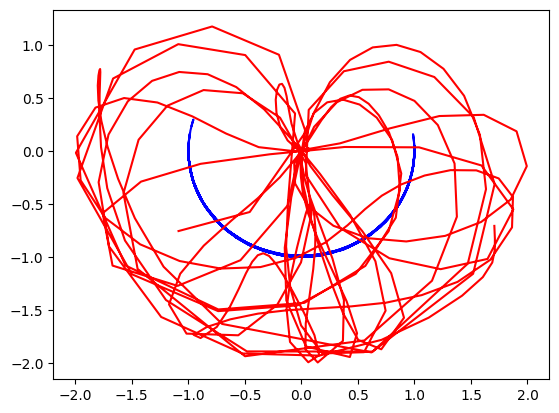

In [10]:
plt.figure()
plt.plot( x1, y1,'b')
plt.plot( x2, y2, 'r')

plt.show()

# Intensity

In [18]:

t,a = genData.generateDynamics(max=1, min = 0.2)
train_dataloader, test_dataloader, train_x, val_x  = loader.getLoader(a,type="Intensity", split = True,   dt=1/100, nInFrames = 5,sr = 10 ,  noise=False, shapeType='simple')
#print(train_x.shape)
#print(val_x.shape)
#print(len(train_dataloader))
#print(len(test_dataloader))

<Figure size 640x480 with 0 Axes>

### Visuals

In [65]:
genData.generateVideo(a,DynamicsType = "Intensity", name = "Intensity_Original_video")

(10000,)


<function matplotlib.pyplot.show(close=None, block=None)>

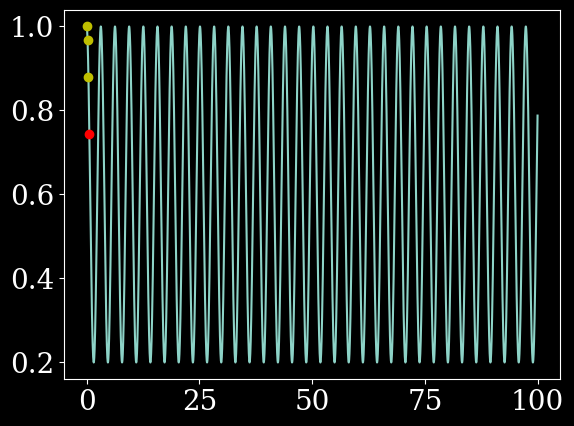

In [106]:
print(a.shape)

plt.figure()
plt.plot(t,a)
sr = 20
for i in range(4):
    if i == 3:
        plt.plot(t[i*sr],a[i*sr],'ro')
    else:
        plt.plot(t[i*sr],a[i*sr],'yo')

plt.show

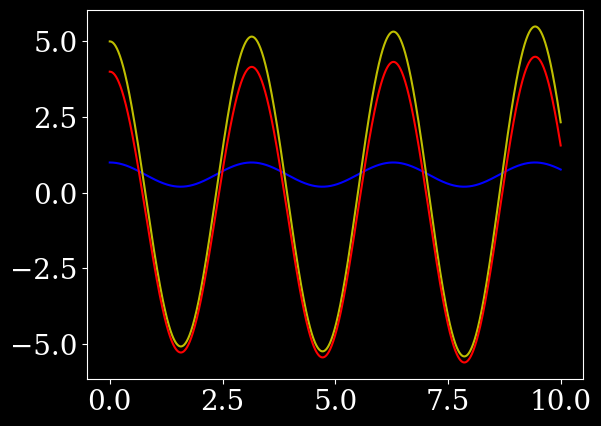

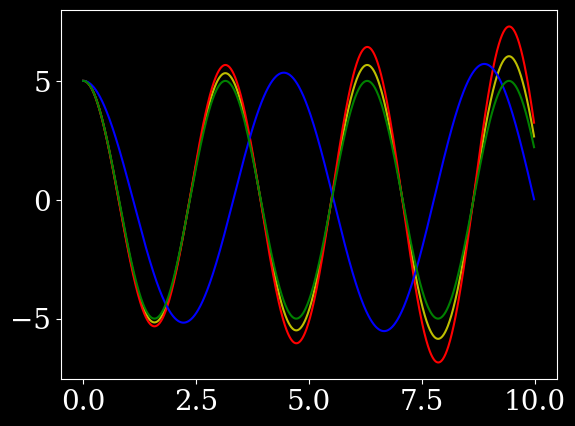

In [49]:
yd = np.zeros(2000)
yd[0]= a[0]*5
yd[1] = a[1]*5
yd[2] = a[2]*5

dt = 1/200

for i in range(2000-3):

    y0 = yd[i]
    y1 = yd[i+1]
    y2 = yd[i+2]

    yd[i+3] = y2 + (y2-y1) + dt*dt*(-4*y1)

plt.figure()
plt.plot(t,a,'b')
plt.plot(t,yd,'y')
plt.plot(t,yd-a,'r')
plt.show()

yd = np.zeros(1000)
td = np.zeros(1000)

td[0]= t[0]
td[1] = t[2]
td[2] = t[4]

yd[0]= a[0]*5
yd[1] = a[2]*5
yd[2] = a[4]*5

dt = 2/200

for i in range(1000-3):

    y0 = yd[i]
    y1 = yd[i+1]
    y2 = yd[i+2]

    yd[i+3] = y2 + (y2-y1) + dt*dt*(-4*y1)

    td[i+3] = td[i+2] + dt

plt.figure()

plt.plot(td,yd,'y')

yd = np.zeros(1000)
td = np.zeros(1000)

td[0]= t[0]
td[1] = t[2]
td[2] = t[4]

yd[0]= a[0]*5
yd[1] = a[2]*5
yd[2] = a[4]*5

dt = 2/200

for i in range(1000-3):

    y0 = yd[i]
    y1 = yd[i+1]
    y2 = yd[i+2]

    yd[i+3] = y2 + (y2-y1) + dt*dt*(-4*y0)

    td[i+3] = td[i+2] + dt
plt.plot(td,yd,'r')

yd = np.zeros(1000)
td = np.zeros(1000)

td[0]= t[0]
td[1] = t[2]
td[2] = t[4]

yd[0]= a[0]*5
yd[1] = a[2]*5
yd[2] = a[4]*5

dt = 2/200

for i in range(1000-3):

    y0 = yd[i]
    y1 = yd[i+1]
    y2 = yd[i+2]

    yd[i+3] = y2 + (y1-y0) + dt*dt*(-4*y0)

    td[i+3] = td[i+2] + dt
plt.plot(td,yd,'b')

yd = np.zeros(1000)
td = np.zeros(1000)

td[0]= t[0]
td[1] = t[2]
td[2] = t[4]

yd[0]= a[0]*5
yd[1] = a[2]*5
yd[2] = a[4]*5

dt = 2/200

for i in range(1000-3):

    y0 = yd[i]
    y1 = yd[i+1]
    y2 = yd[i+2]

    yd[i+3] = y2 + (y2-y1) + dt*dt*(-4*y2)

    td[i+3] = td[i+2] + dt
plt.plot(td,yd,'g')

plt.show()
    

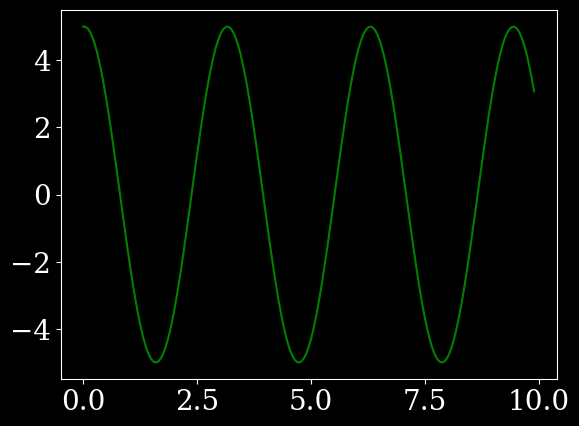

In [50]:
yd = np.zeros(200)
td = np.zeros(200)

td[0]= t[0]
td[1] = t[10]
td[2] = t[10]

yd[0]= a[0]*5
yd[1] = a[10]*5
yd[2] = a[10]*5

dt = 10/200

for i in range(200-3):

    y0 = yd[i]
    y1 = yd[i+1]
    y2 = yd[i+2]

    yd[i+3] = y2 + (y2-y1) + dt*dt*(-4*y2)

    td[i+3] = td[i+2] + dt
plt.plot(td,yd,'g')

plt.show()

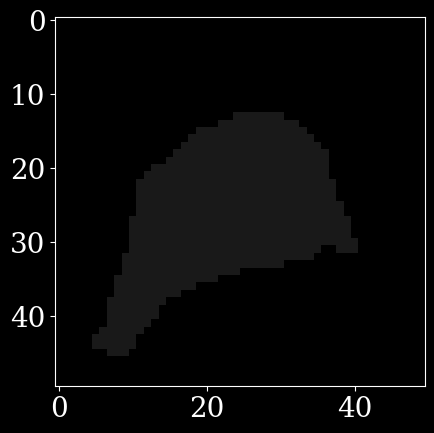

In [51]:
aa = genData.create_intensity_image(0.1, noise=False, shapeType='simple' )

plt.figure()
plt.imshow(aa, cmap='gray', vmax=1, vmin=0)


Batch shape: torch.Size([32, 3, 50, 50])
torch.Size([3, 50, 50])
torch.Size([1, 50, 50])


C:\Users\aleja\AppData\Local\Temp\ipykernel_13316\217011701.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Greys_r', 256)
C:\Users\aleja\AppData\Local\Temp\ipykernel_13316\217011701.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Greys_r', 256)


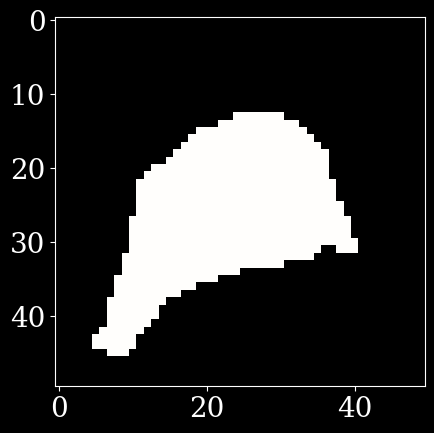

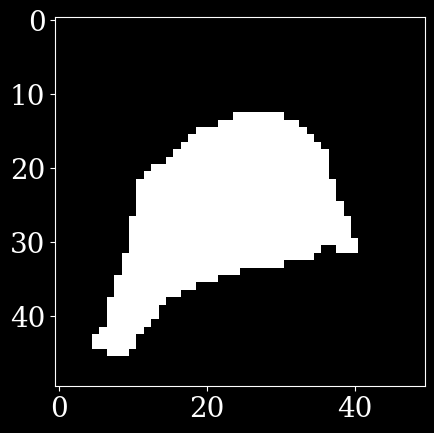

In [9]:
data_iter = iter(train_dataloader)

# Get a batch of data
batch_data = next(data_iter)


# Get the shape of the batch
batch_shape = batch_data[0].shape

print("Batch shape:", batch_shape)

testimage = batch_data[0][0,:,:,:]
cmap = plt.cm.get_cmap('Greys_r', 256)

print(testimage.shape)

# set gray colormap imshow
plt.figure()
plt.imshow(testimage.permute(1, 2, 0), cmap=cmap, interpolation='nearest')

testimage = batch_data[1][30,:,:,:]
cmap = plt.cm.get_cmap('Greys_r', 256)

print(testimage.shape)

# set gray colormap imshow
plt.figure()
plt.imshow(testimage.permute(1, 2, 0), cmap=cmap, interpolation='nearest')

torch.Size([5, 366, 262])


TypeError: Invalid shape (366, 262, 5) for image data

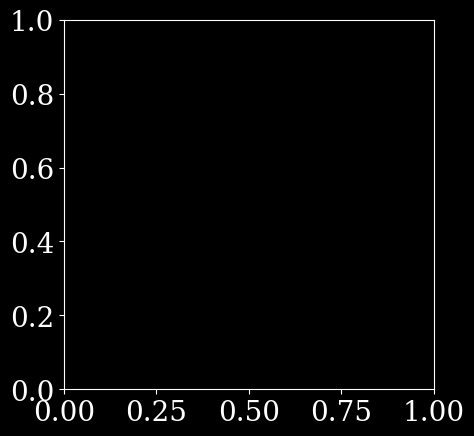

In [20]:
vu.visualize_loader(train_dataloader)

### Model

In [77]:


modelfull= modelineal.AE(dt=0.05, initw=True)
#modelfull= mainmodel.AEModel(dt=0.25, initw=True)#
modelfull, train_losses, val_losses, accuracy_list  = train.train(modelfull, train_dataloader, test_dataloader, 'fullmodel', type='encoder-decoder')



Using device: cpu


epoch: 10 	 training loss: 0.02393619288865011 	 validation loss: 0.27576659790550667
epoch: 20 	 training loss: 0.023681869482970797 	 validation loss: 0.11160225436712305
epoch: 30 	 training loss: 0.023644985924474896 	 validation loss: 0.07640182816733916
epoch: 40 	 training loss: 0.02363846118620131 	 validation loss: 0.06261550278092425
epoch: 50 	 training loss: 0.02367048117215745 	 validation loss: 0.057478685242434345
epoch: 60 	 training loss: 0.023703070355113594 	 validation loss: 0.05563825694844127
epoch: 70 	 training loss: 0.02370201895420905 	 validation loss: 0.05281480976069967
epoch: 80 	 training loss: 0.02352042862563394 	 validation loss: 0.047235113413383566
epoch: 90 	 training loss: 0.023520257283817046 	 validation loss: 0.04210684293260177
epoch: 100 	 training loss: 0.023377364840125665 	 validation loss: 0.0411520516499877


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


alpha,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
beta,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,█▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
alpha,4.0
beta,0.0
train_loss,0.02338
validation_loss,0.04115


<Figure size 640x480 with 0 Axes>

In [55]:
for name, param in modelfull.named_parameters():
    print(name, param.shape, param.requires_grad)

print(modelfull.pModel.alpha[0])
print(modelfull.pModel.beta[0]) 

encoder.linear.0.weight torch.Size([1000, 2500]) True
encoder.linear.0.bias torch.Size([1000]) True
encoder.linear.1.weight torch.Size([500, 1000]) True
encoder.linear.1.bias torch.Size([500]) True
encoder.linear.2.weight torch.Size([1, 500]) True
encoder.linear.2.bias torch.Size([1]) True
decoder.l1.weight torch.Size([10, 1]) True
decoder.l2.weight torch.Size([1000, 10]) True
decoder.l3.weight torch.Size([2500, 1000]) True
pModel.alpha torch.Size([1]) False
pModel.beta torch.Size([1]) False
tensor(4.)
tensor(0.)


In [34]:
def phyModel(y1, y2, dt):
    alpha = 4
    return y2 + (y2-y1) - dt*dt*(alpha*y1)

print(phyModel( 0.9980, 0.9920, 0.05))

0.97602


In [74]:
visual_loader= loader.getLoaderIn(a,  split = False, type = "Dataset3d",  dt=0.05,nInFrames = 3,sr = 10 ,   noise=False, shapeType='simple')
vu.visualize(modelfull, visual_loader, video_name = 'neuronFullModel_ExpVsPred.mp4')
vu.CompareLatent(modelfull, visual_loader)

### Test Decoder

In [8]:
t,a = genData.generateDynamics(max=1, min = 0.2)
train_dataloader, test_dataloader, train_x, val_x  = loader.getLoader_decoder(a, type = "Intensity")
GANDecoder = decoders.convGAN()
GANDecoder, train_losses, val_losses, accuracy_list  = train.trainGAN(GANDecoder, train_dataloader, test_dataloader, '../Results/Intensity_GAN')

Using device: cuda


epoch: 5 	 training loss: 0.2310685070698999
epoch: 10 	 training loss: 0.42702712882082206
epoch: 15 	 training loss: 0.349165072040209
epoch: 20 	 training loss: 0.34118525128139154
epoch: 25 	 training loss: 0.044570964731525595
epoch: 30 	 training loss: 0.37363889617226703
epoch: 35 	 training loss: 0.01542553780145236
epoch: 40 	 training loss: 0.23954369564805292
epoch: 45 	 training loss: 0.033283488811399906
epoch: 50 	 training loss: 0.01682553405696712


train_loss,▆▄▅▄▄▅▄▅██▇█▆▇▇█▅▂▁▁▂▆▇▇▅▁▂▅▁▁▁▄▂▂▂▂▂▁▁▁
train_loss,0.01683


<Figure size 640x480 with 0 Axes>

In [9]:
visual_loader= loader.getLoader_decoder(a, split=False, type = "Intensity")
vu.visualize_dec(GANDecoder.generator, visual_loader, video_name = './Results/Intensity_Decoder_ExpVsPred.mp4')

Video saved as ./Results/Intensity_Decoder_ExpVsPred.mp4


### Test decoder difussion model

In [ ]:
from src.models.cdfm import cdfm as cdfm
t,a = genData.generateDynamics(max=1, min = 0.2)
train_dataloader, test_dataloader, train_x, val_x  = loader.getLoader_decoder(a, type = "Intensity")
diffmodel = cdfm.launch(train_dataloader)

### Integrated fire

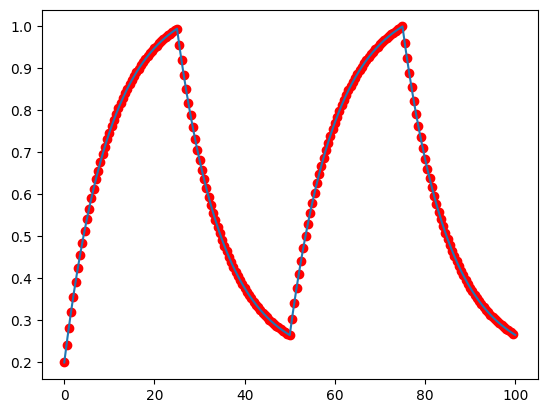

In [48]:
t,a = genData.generateIntegrated_Fire_model()
plt.plot(t,a)
plt.scatter(t[0::50],a[0::50],c='r')
plt.show()

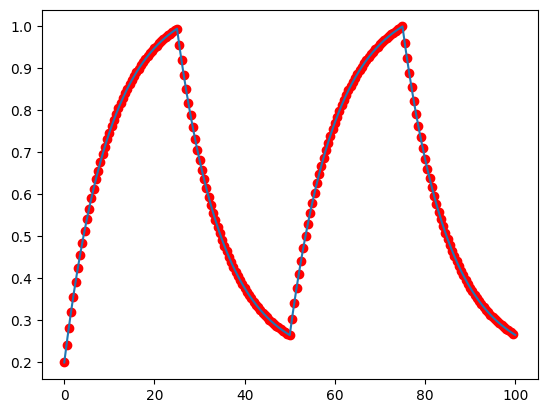

dt_sim 0.01
Using device: cpu


Initial Loss 	 training loss: 15.260044796476638 	 validation loss: 21.369784580577505
epoch: 5 	 training loss: 0.40225741555990935 	 validation loss: 9.649664462696423
epoch: 10 	 training loss: 0.3379943745149445 	 validation loss: 9.874619900096546
epoch: 15 	 training loss: 0.42055120701430204 	 validation loss: 7.440905536304821
epoch: 20 	 training loss: 0.35546013756957934 	 validation loss: 12.084823781793768
epoch: 25 	 training loss: 0.2620249203283631 	 validation loss: 8.58494549664584


R,▁▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███
Vrest,▇██████▇▇▇▇▇▇▇▇▇▆▆▅▅▄▃▂▂▁▁
tau,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,▆█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,█▂▅▃▃▂▂▃▂▂▂▃▂▂▃▁▃▂▂▃▃▁▁▄▃▂
R,-0.11394
Vrest,-0.98954
tau,0.01892
train_loss,0.26202
validation_loss,8.58495


In [45]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:2000"
torch.cuda.empty_cache() 
torch.manual_seed(42)

t,a = genData.generateIntegrated_Fire_model()
sr = 50
dt_sim = t[1]-t[0]
print("dt_sim", dt_sim)
dt = dt_sim*sr
train_dataloader, test_dataloader, train_x, val_x  = loader.getLoader(a,type="Intensity", split = True,  dt=dt_sim, nInFrames = 5,sr = sr ,  noise=False, shapeType='simple')
latentEncoder = mainmodel.EndPhys(dt = dt,pmodel = "IntegratedFire", latent_dim=2, initw=True)
latentEncoder, logs = train.train(latentEncoder, train_dataloader, test_dataloader,  loss_name='latent_loss')

In [46]:
R = latentEncoder.pModel.R[0].detach().cpu().numpy().item()
tau = latentEncoder.pModel.tau[0].detach().cpu().numpy().item()
Vrest = latentEncoder.pModel.Vrest[0].detach().cpu().numpy().item()

print(R, tau, Vrest)

-0.11393675953149796 0.018916470929980278 -0.9895432591438293


In [47]:
print(Vrest/tau, R/tau)

-52.3111981514229 -6.023150933027482


In [51]:
visual_loader= loader.getLoader(a,type="Intensity", split = False,  dt=dt_sim, nInFrames = 5,sr = sr  ,  noise=False, shapeType='simple')
vu.CompareLatent_end_phys(latentEncoder, visual_loader)

<Figure size 640x480 with 0 Axes>

### Test encoder n phys

In [11]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:2000"
torch.cuda.empty_cache() 
torch.manual_seed(42)

t,a = genData.generateDynamics(max=1, min = 0.2)
sr = 40
dt_sim = t[1]-t[0]
print("dt_sim", dt_sim)
dt = dt_sim*sr
train_dataloader, test_dataloader, train_x, val_x  = loader.getLoader(a,type="Intensity", split = True,  dt=dt_sim, nInFrames = 5,sr = sr ,  noise=False, shapeType='simple')
latentEncoder = mainmodel.EndPhys(dt = dt,pmodel = "Damped_oscillation", initw=True)
latentEncoder, logs = train.train(latentEncoder, train_dataloader, test_dataloader,  loss_name='latent_loss')


dt_sim 0.01
Using device: cpu


Initial Loss 	 training loss: 9.54668372576354 	 validation loss: 12.963314641985978
epoch: 5 	 training loss: 0.11982372050845354 	 validation loss: 2.1457502862863373
epoch: 10 	 training loss: 0.16835845903814084 	 validation loss: 2.471032644573011
epoch: 15 	 training loss: 0.15003833055618357 	 validation loss: 2.288754003089771
epoch: 20 	 training loss: 0.13224713990586948 	 validation loss: 2.4245565606836688
epoch: 25 	 training loss: 0.16887837294183794 	 validation loss: 2.3619818645611144


alpha,▁▁▄▆▇█████████████████████
beta,▆█▅▃▂▂▂▂▂▁▂▂▂▁▁▁▂▁▂▁▂▁▁▁▁▁
train_loss,█▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
alpha,3.72778
beta,0.01859
train_loss,0.16888
validation_loss,2.36198


<Figure size 640x480 with 0 Axes>

In [13]:
latentEncoder.pModel.beta[0].detach().cpu().numpy().item()

0.0185901690274477

In [19]:
visual_loader= loader.getLoader(a,type="Intensity", split = False,   dt=1/100, nInFrames = 3,sr = 10 ,  noise=False, shapeType='simple')
vu.CompareLatent_end_phys(latentEncoder, visual_loader)

<Figure size 640x480 with 0 Axes>

# Scale

In [ ]:
t,a = genData.generateDynamics(max=2, min = 0)
train_dataloader, test_dataloader, train_x, val_x  = loader.getLoader(a,type="Scale", split = True,  dt=1/100, nInFrames = 3,sr = 20 ,  noise=False, shapeType='simple')

<Figure size 640x480 with 0 Axes>

### visuals

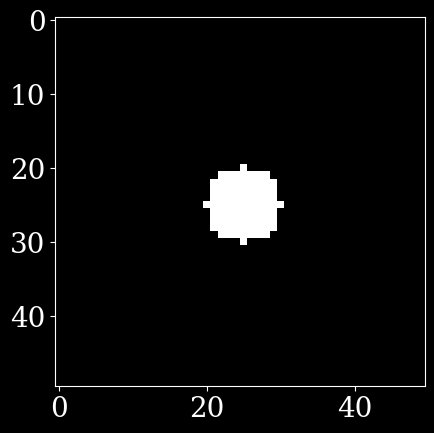

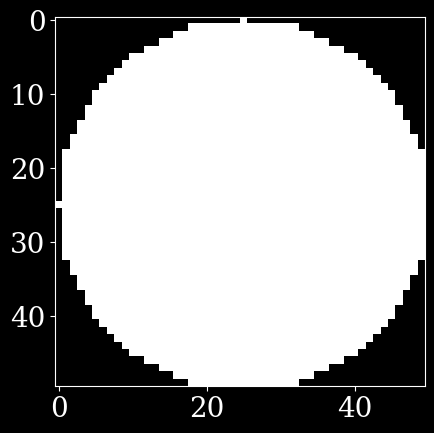

In [ ]:
aa = genData.create_scale_image(0, noise=False, shapeType='simple' )

plt.figure()
plt.imshow(aa, cmap='gray', vmax=1, vmin=0)

aa = genData.create_scale_image(2, noise=False, shapeType='simple' )

plt.figure()
plt.imshow(aa, cmap='gray', vmax=1, vmin=0)

In [ ]:
vu.visualize_loader(train_dataloader)

In [ ]:
genData.generateVideo(a,DynamicsType = "Scale", name = "Scale_Original_video")

### Test Decoder

In [ ]:
train_dataloader, test_dataloader, train_x, val_x  = loader.getLoader_decoder(a, type = "Scale")
linearDecoder = decoders.mlp(initw=True)
linearDecoder, train_losses, val_losses, accuracy_list  = train.train(linearDecoder, train_dataloader, test_dataloader, '../Results/Scale_Decoder', loss_name='decoder_loss')

Using device: cuda


epoch: 10 	 training loss: 0.05719152551144362 	 validation loss: 0.03342188042230331
epoch: 20 	 training loss: 0.056892652474343774 	 validation loss: 0.03397236556674425
epoch: 30 	 training loss: 0.056780308820307254 	 validation loss: 0.03567916749475094
epoch: 40 	 training loss: 0.05668225105851889 	 validation loss: 0.03647880177371777
epoch: 50 	 training loss: 0.05665849100798368 	 validation loss: 0.03686625983279485
epoch: 60 	 training loss: 0.056596668548882005 	 validation loss: 0.03693357468224489
epoch: 70 	 training loss: 0.05653765968978405 	 validation loss: 0.03708248571134531
epoch: 80 	 training loss: 0.05646611392498016 	 validation loss: 0.03717367028674254
epoch: 90 	 training loss: 0.05635320872068405 	 validation loss: 0.03733219607518269
epoch: 100 	 training loss: 0.056242847628891465 	 validation loss: 0.037558308229423486


train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
train_loss,0.05624
validation_loss,0.03756


<Figure size 640x480 with 0 Axes>

In [ ]:
visual_loader= loader.getLoader_decoder(a, split=False, type = "Scale")
vu.visualize_dec(linearDecoder, visual_loader, video_name = './Results/Scale_Decoder_ExpVsPred.mp4')

Video saved as ./Results/Scale_Decoder_ExpVsPred.mp4


### Test Encoder Phys

In [ ]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:2000"
torch.cuda.empty_cache() 
torch.manual_seed(42)


t,a = genData.generateDynamics(max=2, min = 0)
sr = 10
dt_sim = t[1]-t[0]
print("dt_sim", dt_sim)
dt = dt_sim*sr
train_dataloader, test_dataloader, train_x, val_x  = loader.getLoader(a,type="Scale", split = True,  dt=dt_sim, nInFrames = 5,sr = sr ,  noise=False, shapeType='simple')
latentEncoder = mainmodel.EndPhys(dt = dt,pmodel = "Damped_oscillation", initw=True)
latentEncoder, logs = train.train(latentEncoder, train_dataloader, test_dataloader,  loss_name='latent_loss')

Using device: cuda


epoch: 5 	 training loss: 0.0831983064203278 	 validation loss: 5.880365331967671
epoch: 10 	 training loss: 0.09457324856801735 	 validation loss: 5.976184503237406
epoch: 15 	 training loss: 0.08866627315843575 	 validation loss: 6.130231698354085
epoch: 20 	 training loss: 0.08236766554912937 	 validation loss: 5.817626293500265
epoch: 25 	 training loss: 0.08172455830933141 	 validation loss: 6.006799844900767
epoch: 30 	 training loss: 0.08531901880774481 	 validation loss: 5.981741388638814
epoch: 35 	 training loss: 0.09753780782426356 	 validation loss: 6.270526166756948
epoch: 40 	 training loss: 0.09021688880481821 	 validation loss: 5.9914109667142235
epoch: 45 	 training loss: 0.07726214678584775 	 validation loss: 5.997089966138204
epoch: 50 	 training loss: 0.09415612198970458 	 validation loss: 5.94846301873525


alpha,▁▄▆▇████████████████████████████████████
beta,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
alpha,4.07017
beta,1.0
train_loss,0.09416
validation_loss,5.94846


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
visual_loader= loader.getLoader(a,type="Scale", split = False,   dt=1/100, nInFrames = 5,sr = 20 ,  noise=False, shapeType='simple')
vu.CompareLatent_end_phys(latentEncoder, visual_loader)

<Figure size 640x480 with 0 Axes>

# Dataset baseline

### Data exploraion  Physinference paper

In [2]:
data_paid = torch.load("Data/paig_data_test.pt")
print(data_paid.keys())
print(data_paid['masks1'].shape)


data_merge_mask = torch.cat((data_paid['masks1'].unsqueeze(2) ,data_paid['masks2'].unsqueeze(2) ),dim=2)
print(data_merge_mask.shape)

dict_keys(['ims', 'masks1', 'masks2'])
torch.Size([10, 30, 64, 64])
torch.Size([10, 30, 2, 64, 64])


In [3]:
dims = data_merge_mask.shape
new_data = torch.tensor([])
for b in range(0,dims[0]):
    
    data_b = data_merge_mask[b]

    for f in range(0,dims[1]-5):
        
        data_f = data_b[f:f+5]

        data_f = data_f.unsqueeze(0)
        
        
        new_data = data_f if new_data.size()[0] == 0 else torch.cat((new_data, data_f),dim=0)

print(new_data.shape)

    

torch.Size([250, 5, 2, 64, 64])


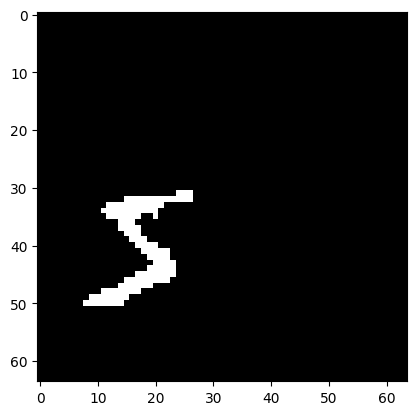

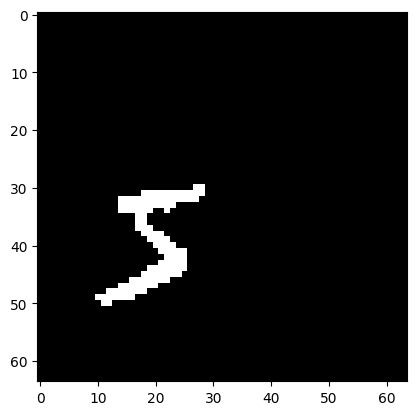

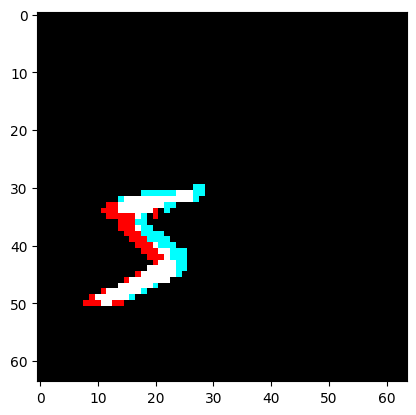

In [34]:
img1 = data_merge_mask[0,0,1,:,:]
img2 = data_merge_mask[0,1,1,:,:]

plt.figure()
plt.imshow(img1, cmap='gray', vmax=1, vmin=0)
plt.figure()
plt.imshow(img2, cmap='gray', vmax=1, vmin=0)
plt.figure()
img_rgb = torch.cat((img1.unsqueeze(2), img2.unsqueeze(2), img2.unsqueeze(2)), dim=2)
plt.imshow( img_rgb, cmap='gray', vmax=1, vmin=0)
plt.show()

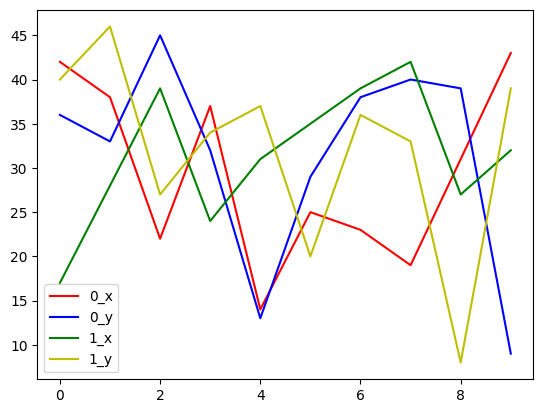

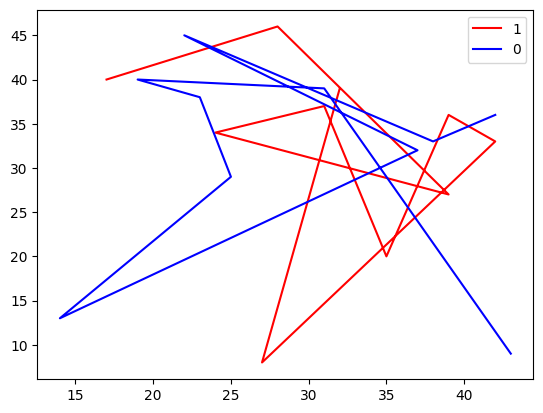

In [14]:
import cv2
import numpy as np

# Load the image




def get_center_mass(image):
    
    image = image.detach().cpu().numpy()*255
    # Threshold the image to create a binary mask
    _, binary_mask = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

    # Calculate moments
    moments = cv2.moments(binary_mask)

    # Calculate center of mass
    if moments['m00'] != 0:
        center_of_mass_x = int(moments['m10'] / moments['m00'])
        center_of_mass_y = int(moments['m01'] / moments['m00'])
        center_of_mass = [center_of_mass_x, center_of_mass_y]
        #print("Center of Mass:", center_of_mass)
    else:
        print("No center of mass found, image is likely empty.")

    return center_of_mass

cm1_list = []
cm0_list = []
for i in range(data_merge_mask.shape[0] ):
    image = data_merge_mask[i,0,1,:,:]
    cm1= get_center_mass(image)
    cm0 = get_center_mass(data_merge_mask[i,0,0,:,:])

    cm1_list.append(cm1)
    cm0_list.append(cm0)


cm0_np = np.array(cm0_list)
cm1_np = np.array(cm1_list)



plt.plot(cm0_np[:,0],'r', label = '0_x' )
plt.plot(cm0_np[:,1],'b', label = '0_y' )
plt.plot(cm1_np[:,0],'g', label = '1_x' )
plt.plot(cm1_np[:,1],'y', label = '1_y' )

plt.legend()

plt.show()

plt.figure()
plt.plot(cm1_np[:,0],cm1_np[:,1],'r', label = '1' )
plt.plot(cm0_np[:,0],cm0_np[:,1],'b', label = '0' )
plt.legend()
plt.show()

dt = 0.3

vel0 = (cm0_np[1:,:] - cm0_np[0:-1,:])*dt

distance = np.sqrt(np.sum((cm0_np[1:,:] - cm1_np[0:-1,:])**2 , axis=1, keepdims=True))

distance =np.linalg.norm(cm0_np[0]-cm0_np[1])

direction = (cm0_np[1:,:] - cm1_np[0:-1,:]) / distance


F = -2*(cm0_np[1:,:] - cm1_np[1:,:]) - 12* ((cm0_np[1:,:] - cm1_np[1:,:]) / np.sqrt(np.sum((cm0_np[1:,:] - cm1_np[1:,:])**2 , axis=1, keepdims=True)))

k =2
L=(12)

F = k*( distance - 2*L  ) * direction

cm0_pred = cm0_np[1:,:] + vel0*dt - F*dt*dt




In [15]:
print(cm0_pred[0:5])
print(cm0_np[2:7])

[[52.004 27.942]
 [16.456 45.396]
 [36.982 34.25 ]
 [ 5.09  -3.074]
 [21.886 24.968]]
[[22 45]
 [37 32]
 [14 13]
 [25 29]
 [23 38]]


In [99]:
print(cm0_np[0:5])
print(cm1_np[0:5])

[[38 33]
 [38 30]
 [39 26]
 [40 24]
 [39 22]]
[[28 46]
 [26 48]
 [24 50]
 [23 52]
 [22 53]]


### Paper phys as an inverse

In [24]:
data_folder = np.load('Data/color_mnist.npz')
data_train = data_folder['train_x']

print(data_train.shape)

(5000, 12, 64, 64, 3)


In [25]:
print(data_train[0,0].max())

254


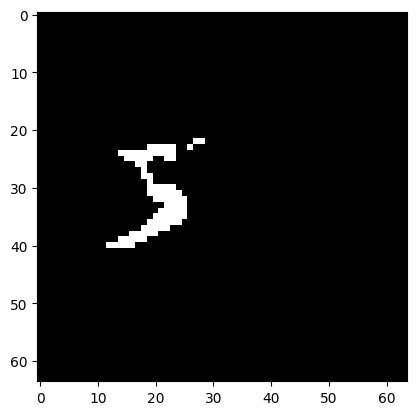

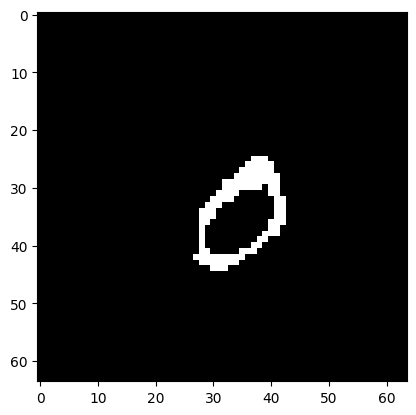

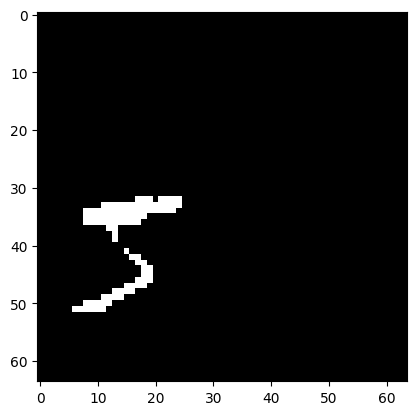

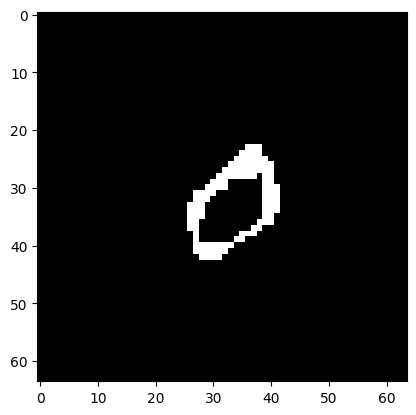

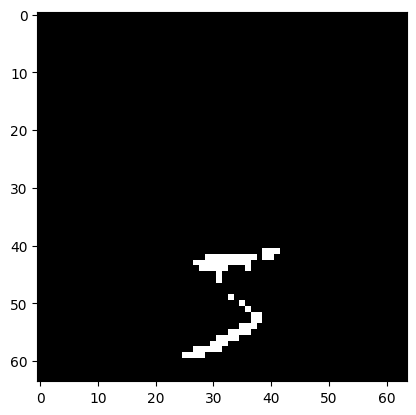

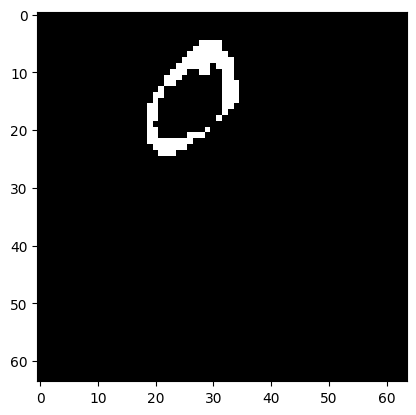

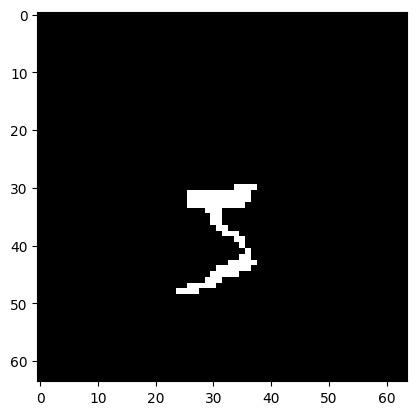

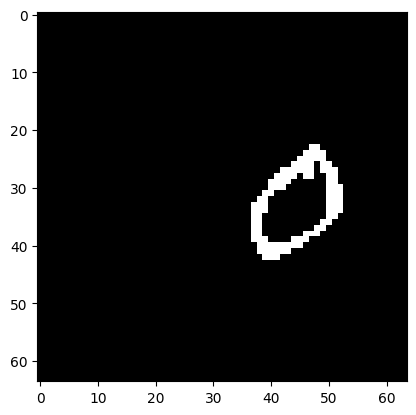

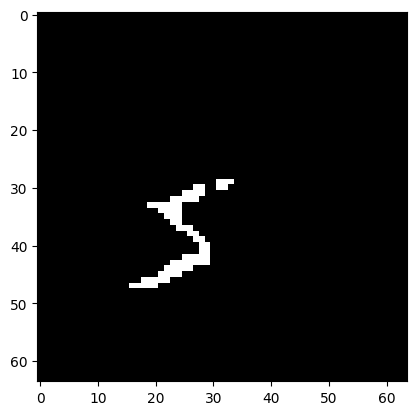

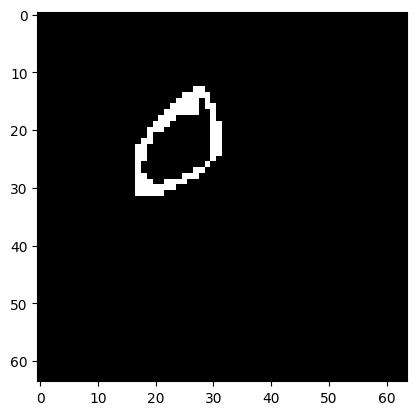

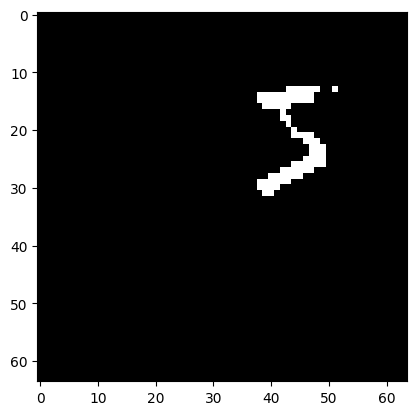

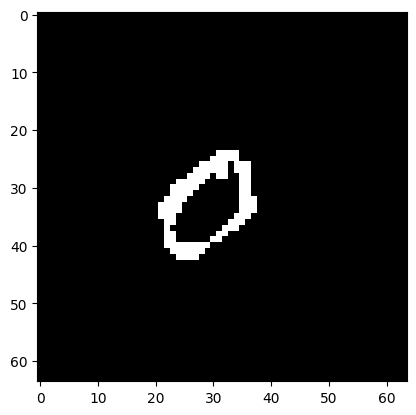

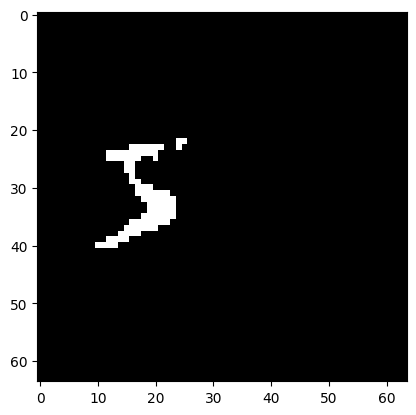

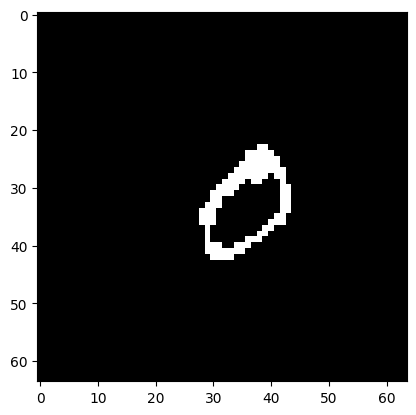

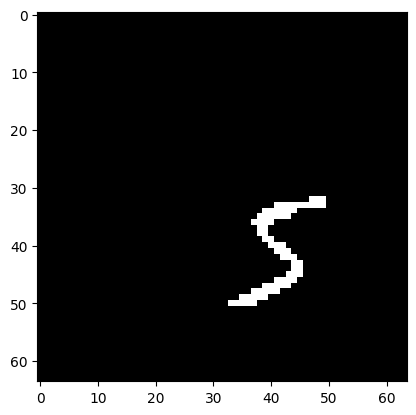

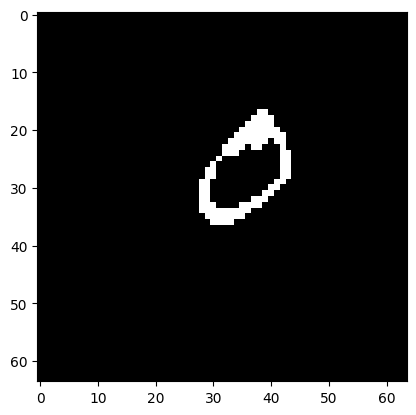

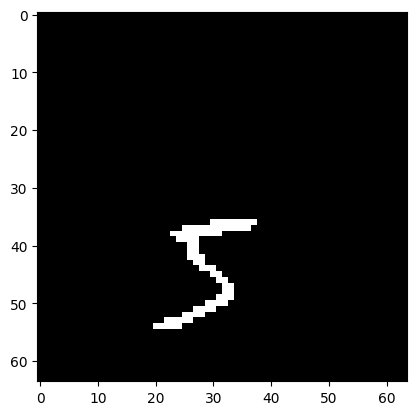

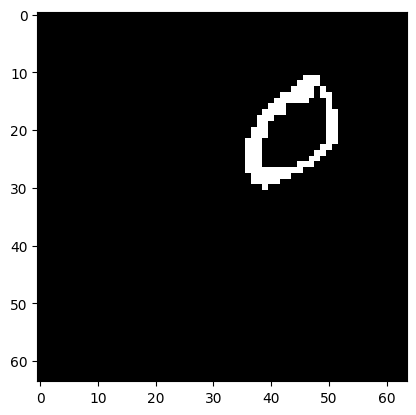

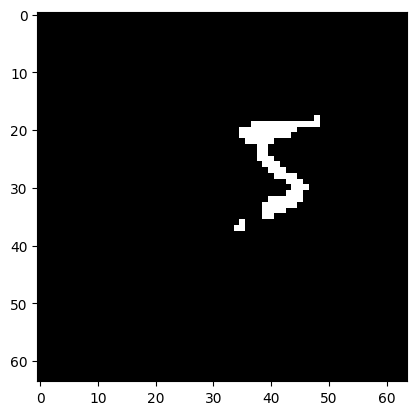

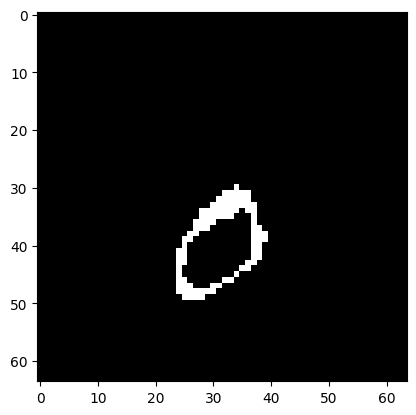

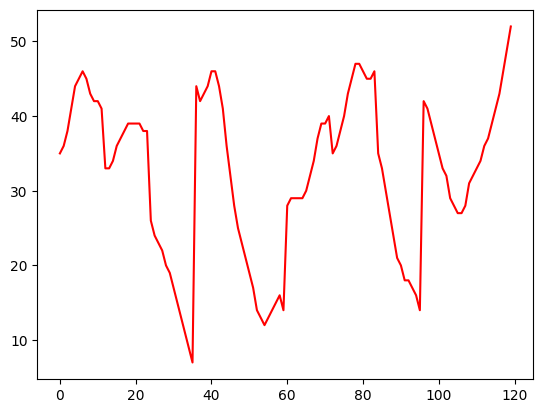

In [44]:
def get_center_mass(image):
    
   
    # Threshold the image to create a binary mask
    _, binary_mask = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

    # Calculate moments
    moments = cv2.moments(binary_mask)

    # Calculate center of mass
    if moments['m00'] != 0:
        center_of_mass_x = int(moments['m10'] / moments['m00'])
        center_of_mass_y = int(moments['m01'] / moments['m00'])
        center_of_mass = [center_of_mass_x, center_of_mass_y]
        #print("Center of Mass:", center_of_mass)
    else:
        print("No center of mass found, image is likely empty.")

    return center_of_mass

data_train[data_train < 205 ] = 0

cm1_list = []
cm0_list = []

for b in range(10):
    
    for i in range(data_train.shape[1] ):
        #i = 0
        red = data_train[b,i,:,:,0]
        blue = data_train[b,i,:,:,1]

        if i == 0:
            plt.figure()
            plt.imshow(red, cmap='gray', vmax=1, vmin=0)
            plt.figure()
            plt.imshow(blue, cmap='gray', vmax=1, vmin=0)
            plt.show()

        cm1= get_center_mass(red)
        cm0 = get_center_mass(blue)

        cm1_list.append(cm1)
        cm0_list.append(cm0)


cm0_np = np.array(cm0_list)
cm1_np = np.array(cm1_list)



plt.plot(cm0_np[:,0],'r', label = '0_x' )
#plt.plot(cm0_np[:,1],'b', label = '0_y' )
#plt.plot(cm1_np[:,0],'g', label = '1_x' )
#plt.plot(cm1_np[:,1],'y', label = '1_y' )

plt.show()



Batch shape: torch.Size([32, 12, 2, 64, 64])
torch.Size([12, 2, 64, 64])


C:\Users\aleja\AppData\Local\Temp\ipykernel_26088\1524344258.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Greys_r', 256)


<Figure size 640x480 with 0 Axes>

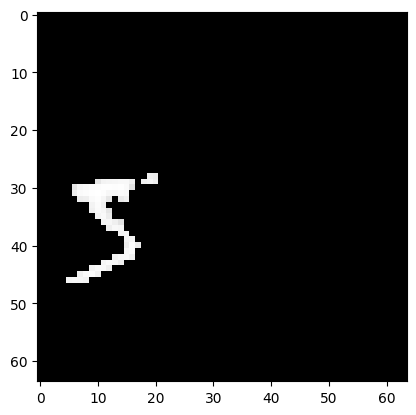

<Figure size 640x480 with 0 Axes>

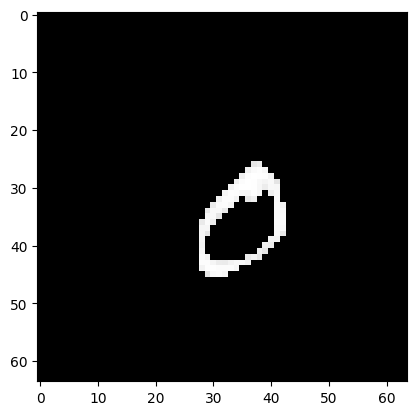

<Figure size 640x480 with 0 Axes>

In [33]:
train_dataloader, test_dataloader, train_x, val_x  = loader.getLoader_folder(data_train, split=True)

data_iter = iter(train_dataloader)

# Get a batch of data
batch_data = next(data_iter)


# Get the shape of the batch
batch_shape = batch_data[0].shape

print("Batch shape:", batch_shape)

testimage = batch_data[0][0,:,:,:]
cmap = plt.cm.get_cmap('Greys_r', 256)

print(testimage.shape)

img_0  = testimage[0,0]
img_1  = testimage[0,1]

# set gray colormap imshow
plt.figure()
plt.imshow(img_0, cmap=cmap, interpolation='nearest')
plt.figure()

plt.figure()
plt.imshow(img_1, cmap=cmap, interpolation='nearest')
plt.figure()


### Model

In [28]:
torch.cuda.empty_cache() 
torch.manual_seed(42)

data_folder = np.load('Data/color_mnist.npz')
data_train = data_folder['train_x']
#
#data_train = new_data

#data_train = data_merge_mask
dt = 0.3
train_dataloader, test_dataloader, train_x, val_x  = loader.getLoader_folder(data_train, split=True)
latentEncoder = mainmodel.EndPhysMultiple(dt = dt, 
                                          in_size=64, 
                                          n_mask = 2, 
                                          in_channels = 2, 
                                          latent_dim=2, 
                                          pmodel = "ODE_2ObjectsSpring", 
                                          init_phys = [1.0,1.0], initw=True)
latentEncoder, log  = train.train(latentEncoder, 
                                            train_dataloader, 
                                            test_dataloader,                                 
                                            loss_name='latent_loss')

Using device: cpu


Initial Loss 	 training loss: 6.990145217895508 	 validation loss: 6.958144992589951
epoch: 3 	 training loss: 3.5391691246032715 	 validation loss: 3.5310006514191628
epoch: 6 	 training loss: 3.5423115406036376 	 validation loss: 3.530600383877754
epoch: 9 	 training loss: 3.543502063751221 	 validation loss: 3.525351896882057
epoch: 12 	 training loss: 3.534821371078491 	 validation loss: 3.54989305883646
epoch: 15 	 training loss: 3.5447178802490233 	 validation loss: 3.5758882611989975


eq_distance,█▄▃▃▂▂▁▂▂▂▂▁▁▁▁▁
k,█▁▃▄▄▄▄▄▄▄▄▄▄▄▄▄
train_loss,▆█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eq_distance,0.02135
k,-0.38579
train_loss,3.54472
validation_loss,3.57589


In [22]:
visual_loader  = loader.getLoader_folder(data_train, split=False)


<Figure size 640x480 with 0 Axes>

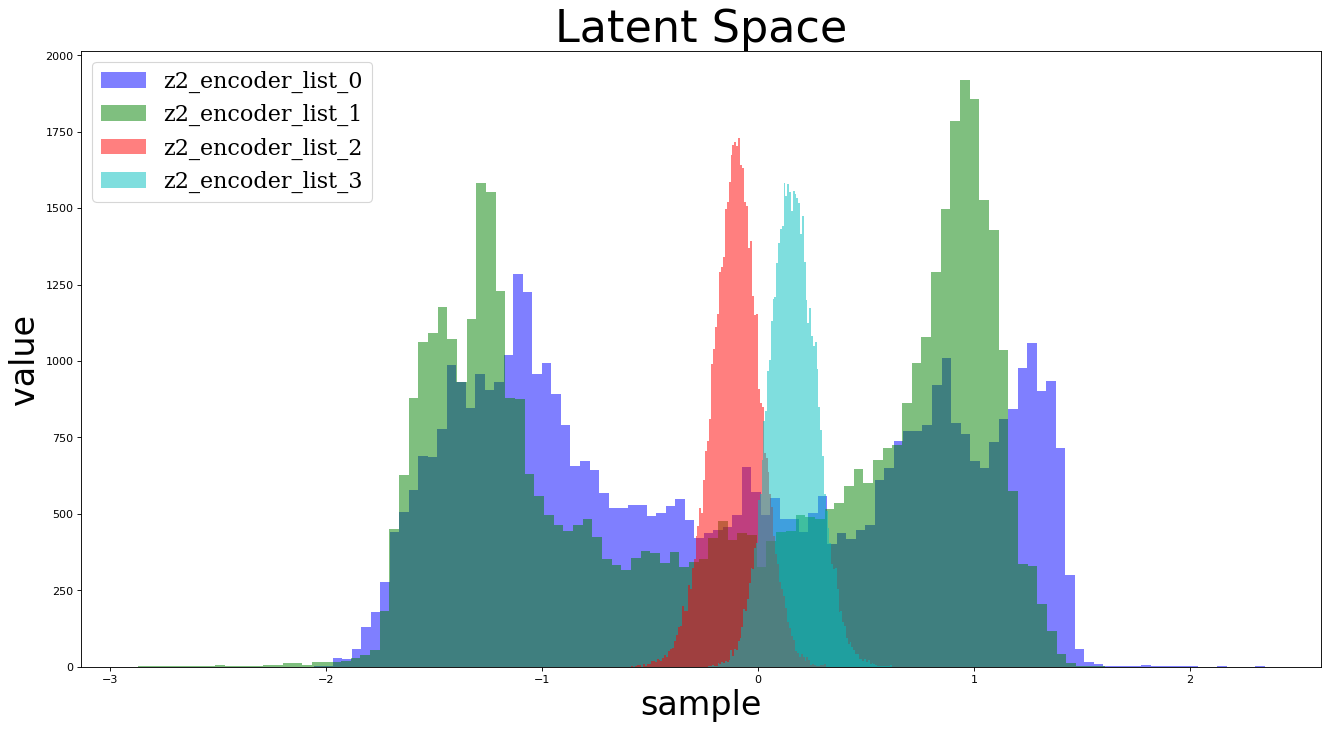

In [23]:
vu.visualize_latent_dist (latentEncoder, visual_loader)

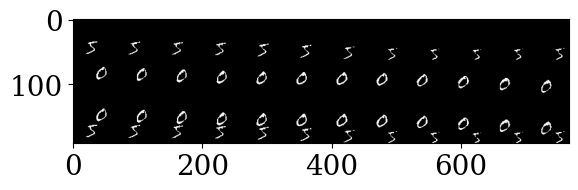

(10, 4)
(10, 4)


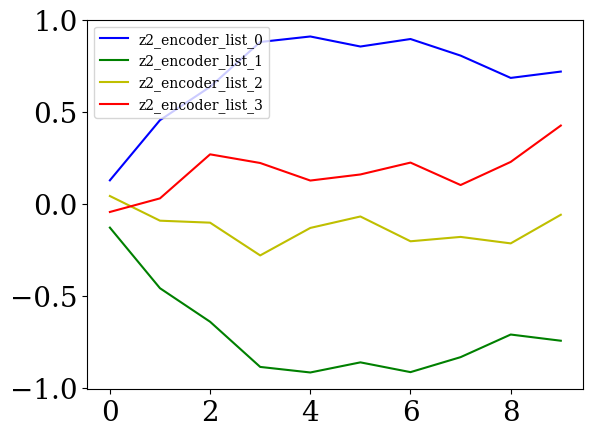

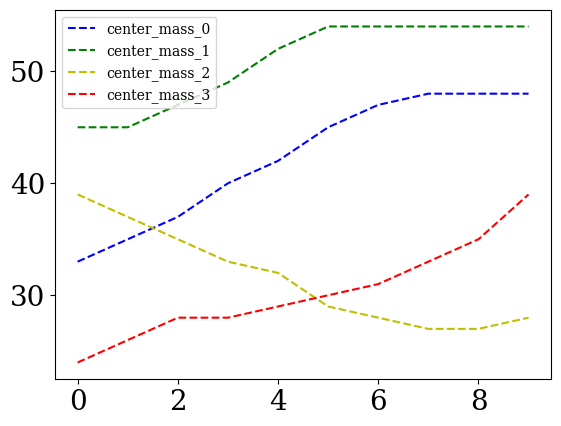

In [29]:
vu.visualize_cm(latentEncoder, visual_loader)

In [10]:
a = torch.randn(2,2,4)
print(a)
a = a.reshape(-1, a.shape[2],2)
print(a)

mu = a.mean(dim=0)
print(mu)
print(mu+1)

tensor([[[-0.1735, -0.9714, -0.1222,  1.1298],
         [ 1.7157, -0.7542,  1.5696, -0.6647]],

        [[-2.1150, -0.3570, -1.1184, -1.4649],
         [ 0.0754,  2.0932,  0.4815,  0.2629]]])
tensor([[[-0.1735, -0.9714],
         [-0.1222,  1.1298],
         [ 1.7157, -0.7542],
         [ 1.5696, -0.6647]],

        [[-2.1150, -0.3570],
         [-1.1184, -1.4649],
         [ 0.0754,  2.0932],
         [ 0.4815,  0.2629]]])
tensor([[-1.1442, -0.6642],
        [-0.6203, -0.1676],
        [ 0.8955,  0.6695],
        [ 1.0256, -0.2009]])
tensor([[-0.1442,  0.3358],
        [ 0.3797,  0.8324],
        [ 1.8955,  1.6695],
        [ 2.0256,  0.7991]])


In [17]:
print(latentEncoder.pModel.k[0].detach().cpu().numpy().item())
print(latentEncoder.pModel.eq_distance[0].detach().cpu().numpy().item())

0.012577783316373825
5.0705037117004395


### MNIST moving

In [24]:
torch.cuda.empty_cache() 
torch.manual_seed(42)

data_folder = np.load('Data/color_mnist.npz')
data_train = data_folder['train_x']
dt = 0.3
train_dataloader, test_dataloader, train_x, val_x  = loader.getLoader_folder(data_train, split=True)
latentEncoder = mainmodel.EndPhys(dt = dt, in_size=64, n_mask = 2, in_channels = 3, latent_dim=4, initw=True)
#latentEncoder = mainmodel.EndPhysMultiple(dt = dt, in_size=64, n_mask = 2, in_channels = 3, latent_dim=2, initw=True)
latentEncoder, train_losses, val_losses, accuracy_list  = train.train(latentEncoder, train_dataloader, test_dataloader, '../Results/Motion_Decoder', loss_name='latent_loss')

In [ ]:
visual_loader  = loader.getLoader_folder(data_train, split=False)
vu.view_masks(latentEncoder, visual_loader, iters = 2)

In [40]:
print(data_train.shape)
print(data_train[0].shape)
print(data_train[0].transpose( (0,3,1,2) ).shape)


(5000, 12, 64, 64, 3)
(12, 64, 64, 3)
(12, 3, 64, 64)


max: 254


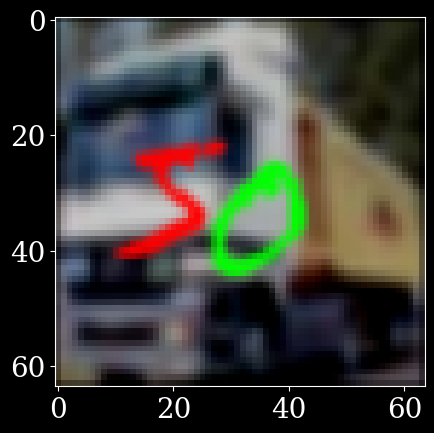

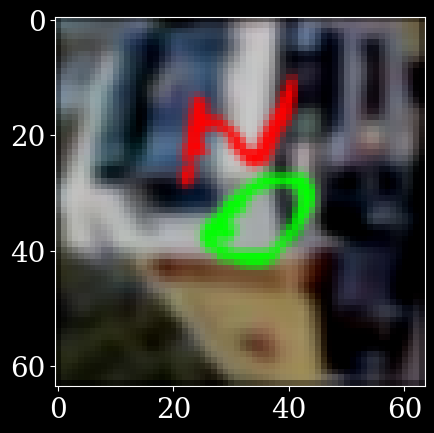

In [31]:
data_train[0,0,:,:,:].shape

print("max:", np.max(data_train[0,0,:,:,:]))

plt.figure()
plt.imshow(data_train[0,0,:,:,:])
plt.show()

data_train2 = data_train[0].transpose( (0,3,1,2))

test_img = data_train2[0,:,:,:]

plt.figure()

plt.imshow(test_img.transpose(2, 1, 0))
plt.show()


### custom mnist

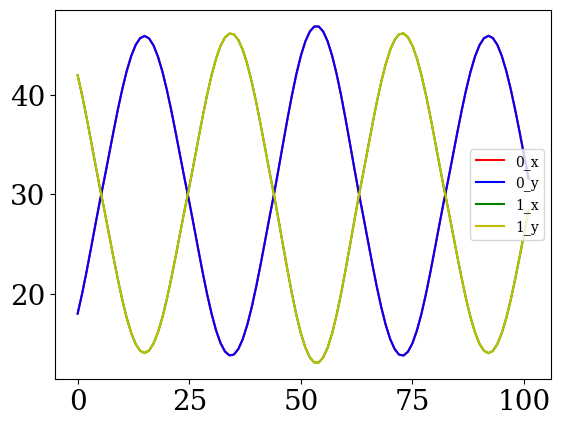

In [51]:
p0 = np.array([20,20])
p0_past = np.array([18,18])

p1 = np.array([40, 40])
p1_past = np.array([42, 42])

def force(p0, p1):
    k = 2
    L = 12
    F = k*(np.linalg.norm(p0-p1) - L)*(p1-p0)/np.linalg.norm(p0-p1)
    return F

def prediction(p0, p1, p0_past, p1_past, F):
    dt = 0.1
    p0_new = 2*p0 - p0_past + F*dt*dt
    p1_new = 2*p1 - p1_past - F*dt*dt
    return p0_new, p1_new

p0_list = []
p1_list = []

p0_list.append(p0_past)
p1_list.append(p1_past)

p0_list.append(p0)
p1_list.append(p1)

for i in range(100):
    F = force(p0, p1)
    p0_new, p1_new = prediction(p0, p1, p0_past, p1_past, F)
    p0_past = p0
    p1_past = p1
    p0 = p0_new
    p1 = p1_new
    p0_list.append(p0)
    p1_list.append(p1)

p0_np = np.array(p0_list)
p1_np = np.array(p1_list)

plt.plot(p0_np[:,0],'r', label = '0_x' )
plt.plot(p0_np[:,1],'b', label = '0_y' )
plt.plot(p1_np[:,0],'g', label = '1_x' )
plt.plot(p1_np[:,1],'y', label = '1_y' )
plt.legend()
plt.show()
    

In [61]:
#get mnist digit
from keras.datsets import mnist
data = mnist.load_data()

ModuleNotFoundError: No module named 'tensorflow'

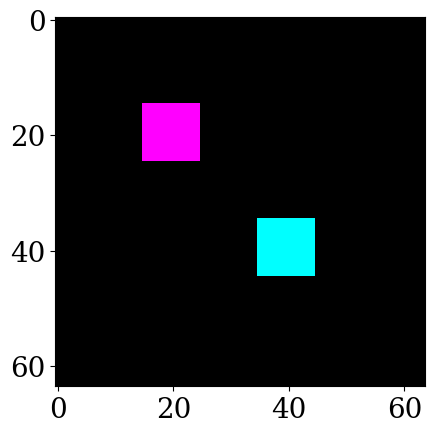

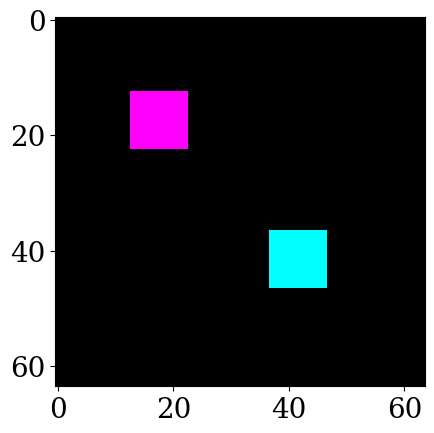

In [84]:
#from keras.datasets import mnist
#data = mnist.load_data()

#import draw
import numpy as np
import matplotlib.pyplot as plt

import cv2 


def create_mnist_spring_frame(p1,p2):
    #Create a blank image
    mask1 = np.zeros((64,64))
    mask2 = np.zeros((64,64))

    size_obj = 10
    half= size_obj//2
    

    #create square 1 
    s1 = np.ones((size_obj,size_obj))

    #create square 2
    s2 = np.ones((size_obj,size_obj))

    #aling squares to img
    p1 = p1.astype(int)
    p2 = p2.astype(int)
    s1 = s1.astype(int)
    s2 = s2.astype(int)

    mask1[p1[0]-half:p1[0]+half,p1[1]-half:p1[1]+half] = s1
    mask2[p2[0]-half:p2[0]+half,p2[1]-half:p2[1]+half] = s2
    
    mask1  = mask1.reshape(1,64,64)
    mask2  = mask2.reshape(1,64,64)
    
    sum_mask = mask1 + mask2

    
    img = np.concatenate((mask1,mask2,sum_mask), axis=0)
 

    
    return img

def create_mnist_spring_video(p1_list,p2_list):

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    #fourcc = cv2.VideoWriter_fourcc(*'XVID')
    h = 64
    frame_rate = 2
    
    
    frames = []
    for i in range(len(p1_list)):
        ##print(i)
        p1 = p1_list[i]
        p2 = p2_list[i]
        ##print(p1)
        ##print(p2)
        frame = create_mnist_spring_frame(p1,p2)
        frame = frame.transpose(1,2,0)
        frames.append(frame)

    # create video
    video = cv2.VideoWriter('Custom_mnist.mp4', fourcc, frame_rate, ( h ,h ))
    for i in range(len(frames)):

        frame = frames[i]
        #print(frame.shape)
        #print(frame.max())
        #break
        #frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        #frame = np.uint8(frame*255)
        frame = frame*255
        frame[frame>255] = 255
        frame = np.uint16(frame)
        if i == 0:
            plt.figure()
            plt.imshow(frame)
            plt.show()
            break
        video.write(frame)
    video.release()



    return frames

p1 = np.array([20,20])
p2 = np.array([40,40])
frame = create_mnist_spring_frame(p1,p2)

frame = frame.transpose(1,2,0)
plt.figure()
plt.imshow(frame)
plt.show()

frames = create_mnist_spring_video(p0_np,p1_np)



### 3 body gravity

In [16]:
torch.cuda.empty_cache() 
torch.manual_seed(0)

data_folder = np.load('Data/color_3bp.npz')
data_train = data_folder['train_x']
dt = 0.5
train_dataloader, test_dataloader, train_x, val_x  = loader.getLoader_folder(data_train, split=True)
latentEncoder = mainmodel.EndPhys(dt = dt, in_size=36, n_mask = 2, in_channels = 3, latent_dim=6, pmodel = "gravity_ode", initw=True)
#latentEncoder = mainmodel.EndPhysMultiple(dt = dt, in_size=64, n_mask = 2, in_channels = 3, latent_dim=2, initw=True)
latentEncoder, train_losses, val_losses, accuracy_list  = train.train(latentEncoder, train_dataloader, test_dataloader, '../Results/3bpn_Decoder', loss_name='latent_loss')

Using device: cpu


Nan values in gravity_ode
Nan values in gravity_ode
loss tensor(nan)


UnboundLocalError: cannot access local variable 'epoch' where it is not associated with a value

In [10]:
a = torch.randn(3, 2)
print(a)
print(a+1e1)




tensor([[ 0.5615, -1.0040],
        [-2.1960,  0.7584],
        [ 0.8105,  1.5970]])
tensor([[10.5615,  8.9960],
        [ 7.8040, 10.7584],
        [10.8105, 11.5970]])


In [96]:
x1 = a[1,0,0]
y1 = a[1,0,1]
x2 = a[1,2,0]
y2 = a[1,2,1]

manual_distance = torch.sqrt((x2-x1)**2 + (y2-y1)**2)
print(manual_distance)
manual_distance = manual_distance +1e-5
print(manual_distance)
manual_distance = manual_distance.pow(3)
print(manual_distance)
manual_distance = 1/manual_distance

print(manual_distance)


tensor(0.5709)
tensor(0.5709)
tensor(0.1861)
tensor(5.3735)


In [71]:
print(torch.div( direction[:,:,:].transpose(1,2), distance[:,:]) .transpose(1,2))

print(torch.matmul( direction[:,:,:].transpose(1,2), 1/(distance[:,:].unsqueeze(2)) ) .transpose(1,2))

print(direction[0,0,:]/distance[0,0])
print(direction[0,1,:].T/distance[0,1])
print(direction[0,2,:].T/distance[0,2])

print(direction[1,0,:].T/distance[1,0])
print(direction[1,1,:].T/distance[1,1])
print(direction[1,2,:].T/distance[1,2])

tensor([[[ 0.0674,  1.0867],
         [-0.5231, -0.4149],
         [ 0.4128, -1.0972]],

        [[ 0.3425, -0.9278],
         [-1.4141,  0.7252],
         [ 0.8301,  0.0015]]])
tensor([[[-0.0429, -0.7654]],

        [[ 0.6846, -0.2011]]])
tensor([0.0674, 0.9977])
tensor([-0.5231, -0.8522])
tensor([ 0.4128, -0.9108])
tensor([ 0.3731, -0.9278])
tensor([-0.6885,  0.7252])
tensor([1.0000, 0.0015])


In [34]:
data_folder = np.load('Data/color_3bp.npz')
data_train = data_folder['train_x']

print(data_train.shape)

(5000, 20, 36, 36, 3)


# Test

In [22]:
a = torch.randn(3,1, 4)
b = torch.randn(3,1, 4)

print(a)
print(b)
c =torch.cat((a,b),dim=1)
print(c)

tensor([[[-7.3805e-01, -2.8412e-01,  5.6924e-01, -4.9533e-01]],

        [[ 5.5396e-02,  3.9195e-01, -4.3198e-01,  1.1892e-03]],

        [[-1.1370e+00,  1.2295e+00,  5.5216e-01, -5.9665e-01]]])
tensor([[[-0.0816,  0.8206, -0.4337, -0.2885]],

        [[ 1.7397,  1.6752, -1.1684, -1.6519]],

        [[-0.1189, -1.1454,  0.9931,  0.8348]]])
tensor([[[-7.3805e-01, -2.8412e-01,  5.6924e-01, -4.9533e-01],
         [-8.1572e-02,  8.2057e-01, -4.3368e-01, -2.8846e-01]],

        [[ 5.5396e-02,  3.9195e-01, -4.3198e-01,  1.1892e-03],
         [ 1.7397e+00,  1.6752e+00, -1.1684e+00, -1.6519e+00]],

        [[-1.1370e+00,  1.2295e+00,  5.5216e-01, -5.9665e-01],
         [-1.1889e-01, -1.1454e+00,  9.9315e-01,  8.3479e-01]]])


In [16]:
points = torch.rand(2, 6)  # Generate random points

# Reshape the tensor to have 3 dimensions: (32, 3, 2)
points_3d = points.view(-1, 3, 2)

# Calculate the Euclidean distance between each pair of points
distances = torch.norm(points_3d, dim=2)


distances_torch = torch.cdist(points_3d, points_3d)

distance_manual = torch.sqrt(torch.sum((points_3d[:, None] - points_3d[None, :])**2, dim=-1))




In [17]:
#points = torch.rand(1, 3,2)

permute = torch.roll(points, -1,1)



print(points)
print(permute)


print(points - permute)

cdist = torch.cdist(points, permute)

print(cdist)

x0 = points[0,1,0]
y0 = points[0,1,1]
x1 = points[0,2,0]
y1 = points[0,2,1]

distance = torch.sqrt((x1-x0)**2 + (y1-y0)**2)

print(distance)



tensor([[0.0944, 0.2023, 0.7417, 0.1125, 0.7581, 0.1556],
        [0.5427, 0.6921, 0.6357, 0.3110, 0.8238, 0.1230]])
tensor([[0.2023, 0.7417, 0.1125, 0.7581, 0.1556, 0.0944],
        [0.6921, 0.6357, 0.3110, 0.8238, 0.1230, 0.5427]])
tensor([[-0.1079, -0.5394,  0.6292, -0.6456,  0.6025,  0.0612],
        [-0.1494,  0.0564,  0.3247, -0.5128,  0.7008, -0.4197]])
tensor([[1.2174, 1.3378],
        [1.0194, 1.0302]])


IndexError: too many indices for tensor of dimension 2

In [ ]:
points = torch.rand(1, 6)

print(points.view(-1, 3, 2))
print(points.view(points.shape[0], -1, 2))


tensor([[[0.0766, 0.8460],
         [0.3624, 0.3083],
         [0.0850, 0.0029]]])
tensor([[[0.0766, 0.8460],
         [0.3624, 0.3083],
         [0.0850, 0.0029]]])


In [ ]:
print(distances_torch)
print(points_3d)

print(distance_manual)

tensor([[[0.0000, 0.5122, 0.9567],
         [0.5122, 0.0000, 0.5930],
         [0.9567, 0.5930, 0.0000]],

        [[0.0000, 0.5621, 0.5425],
         [0.5621, 0.0000, 0.0827],
         [0.5425, 0.0827, 0.0000]]])
tensor([[[0.9516, 0.0753],
         [0.8860, 0.5832],
         [0.3376, 0.8090]],

        [[0.5779, 0.9040],
         [0.5547, 0.3423],
         [0.6343, 0.3644]]])
tensor([[[0.0000, 0.0000, 0.0000],
         [0.9090, 0.4097, 0.5345]],

        [[0.9090, 0.4097, 0.5345],
         [0.0000, 0.0000, 0.0000]]])


In [ ]:
x0 = points_3d[0,2,0]
y0 = points_3d[0,2,1]
x1 = points_3d[0,1,0]
y1 = points_3d[0,1,1]

distance = torch.sqrt((x1-x0)**2 + (y1-y0)**2)
print(distance)

aa = points_3d[0,:,:]
print(aa.shape)

distances_torch = torch.cdist(aa, aa)
print(distances_torch)

tensor(0.5930)
torch.Size([3, 2])
tensor([[0.0000, 0.5122, 0.9567],
        [0.5122, 0.0000, 0.5930],
        [0.9567, 0.5930, 0.0000]])


In [ ]:
Data = np.load('Data/color_mnist.npz')

In [ ]:
print(Data['train_x'].shape)

(5000, 12, 64, 64, 3)


In [ ]:
x = torch.rand(2,4)
print(x)

# reshape x to 3d tensor size 2x2
x = x.view(-1, 2, 2)
print(x)
print(x.shape)

tensor([[0.1194, 0.5001, 0.1685, 0.3910],
        [0.6614, 0.2581, 0.2352, 0.7478]])
tensor([[[0.1194, 0.5001],
         [0.1685, 0.3910]],

        [[0.6614, 0.2581],
         [0.2352, 0.7478]]])
torch.Size([2, 2, 2])


In [ ]:
x = torch.rand(2,4)
print(x)

# reshape x to 3d tensor size 2x2

x = x.reshape(-1, 2, 2)
print(x)
print(x.shape)

tensor([[0.0610, 0.2224, 0.3052, 0.3651],
        [0.2652, 0.7166, 0.0498, 0.3509]])
tensor([[[0.0610, 0.2224],
         [0.3052, 0.3651]],

        [[0.2652, 0.7166],
         [0.0498, 0.3509]]])
torch.Size([2, 2, 2])


In [ ]:
x = torch.rand(32,50,50)
x = x.view(x.shape[0], -1)
print(x.shape)

x = torch.rand(32,3,50,50)
x = x.view(x.shape[0], -1)
print(x.shape)

torch.Size([32, 2500])
torch.Size([32, 7500])


### Difussion things

t tensor([11, 13,  6, 34, 81, 67, 64, 97, 74, 82])
t_unsqueeze tensor([[11.],
        [13.],
        [ 6.],
        [34.],
        [81.],
        [67.],
        [64.],
        [97.],
        [74.],
        [82.]])
inv_freq tensor([1.0000e+00, 1.5849e-01, 2.5119e-02, 3.9811e-03, 6.3096e-04])
tensor([[-1.0000,  0.9851,  0.2728,  0.0438,  0.0069],
        [ 0.4202,  0.8825,  0.3208,  0.0517,  0.0082],
        [-0.2794,  0.8140,  0.1501,  0.0239,  0.0038],
        [ 0.5291, -0.7799,  0.7539,  0.1349,  0.0215],
        [-0.6299,  0.2679,  0.8943,  0.3169,  0.0511],
        [-0.8555, -0.9299,  0.9937,  0.2636,  0.0423],
        [ 0.9200, -0.6583,  0.9993,  0.2520,  0.0404],
        [ 0.3796,  0.3283,  0.6481,  0.3766,  0.0612],
        [-0.9851, -0.7434,  0.9588,  0.2904,  0.0467],
        [ 0.3132,  0.4166,  0.8828,  0.3207,  0.0517]])
pos_enc torch.Size([10, 10])


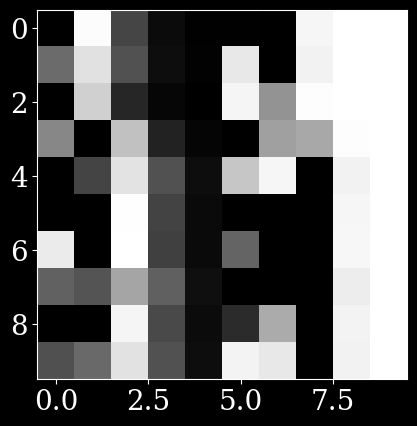

t_pos_encoding tensor([[-1.0000,  0.9851,  0.2728,  0.0438,  0.0069,  0.0044, -0.1717,  0.9621,
          0.9990,  1.0000],
        [ 0.4202,  0.8825,  0.3208,  0.0517,  0.0082,  0.9074, -0.4702,  0.9472,
          0.9987,  1.0000],
        [-0.2794,  0.8140,  0.1501,  0.0239,  0.0038,  0.9602,  0.5809,  0.9887,
          0.9997,  1.0000],
        [ 0.5291, -0.7799,  0.7539,  0.1349,  0.0215, -0.8486,  0.6259,  0.6569,
          0.9909,  0.9998],
        [-0.6299,  0.2679,  0.8943,  0.3169,  0.0511,  0.7767,  0.9634, -0.4474,
          0.9485,  0.9987],
        [-0.8555, -0.9299,  0.9937,  0.2636,  0.0423, -0.5178, -0.3679, -0.1119,
          0.9646,  0.9991],
        [ 0.9200, -0.6583,  0.9993,  0.2520,  0.0404,  0.3919, -0.7528, -0.0368,
          0.9677,  0.9992],
        [ 0.3796,  0.3283,  0.6481,  0.3766,  0.0612, -0.9251, -0.9446, -0.7616,
          0.9264,  0.9981],
        [-0.9851, -0.7434,  0.9588,  0.2904,  0.0467,  0.1717,  0.6688, -0.2840,
          0.9569,  0.9989],
    

In [ ]:
def pos_encoding( t, channels):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2).float() / channels)
        )
        print("inv_freq", inv_freq)
        print(torch.sin(t.repeat(1, channels // 2)* inv_freq))
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        print("pos_enc", pos_enc.shape)

        plt.figure()
        plt.imshow(pos_enc, cmap='gray', vmax=1, vmin=0)
        plt.show()

        return pos_enc
t = torch.randint(low=1, high=100, size=(10,))
print("t", t)
t = t.unsqueeze(-1).type(torch.float)
print("t_unsqueeze", t)
t = pos_encoding(t, 10)
print("t_pos_encoding", t)

le tensor(1.2582, grad_fn=<MaxBackward1>)
le tensor(-0.8530, grad_fn=<MinBackward1>)
t torch.Size([10, 10])
t_label_emb torch.Size([10, 10])


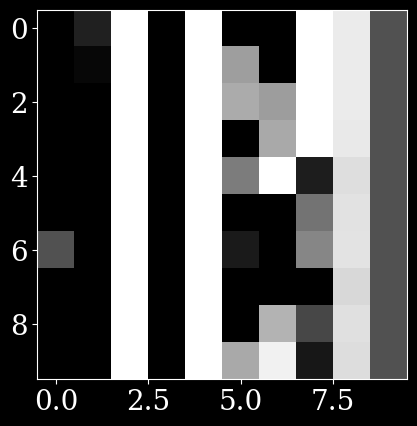

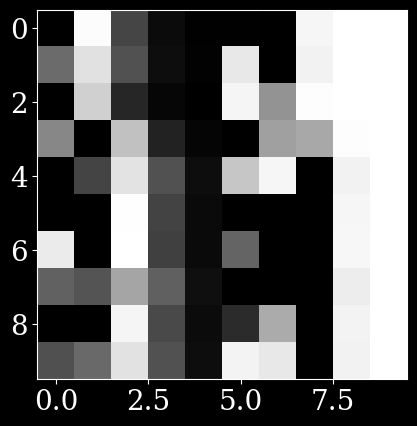

In [ ]:
label_emb = nn.Embedding(1, 10)

y = torch.tensor([0])

le = label_emb(y)
print("le", le.max())
print("le", le.min())
t2 = t+ le
print("t", t.shape)
print("t_label_emb", t2.shape)
#print("t", t)
#print("t_label_emb", t2)

plt.figure()
plt.imshow(t2.detach().numpy(), cmap='gray', vmax=1, vmin=0)
plt.show()
plt.figure()
plt.imshow(t.detach().numpy(), cmap='gray', vmax=1, vmin=0)
plt.show()

### images

In [ ]:
# Assuming batch size is 32 and images are grayscale with dimensions (height, width)
batch_size = 32
height, width = 28, 28  # Example dimensions, adjust as per your images

# Generate a random batch of images (example)
batch_images = torch.rand(batch_size, height, width)

# Reshape the batch to (batch_size, num_pixels)
batch_images_flat = batch_images.view(batch_size, -1)

print(batch_images_flat.shape)
print(batch_images.shape)

# Calculate the variance across the batch for each pixel
variances = torch.var(batch_images_flat, dim=0)

print(variances.shape)

torch.Size([32, 784])
torch.Size([32, 28, 28])
torch.Size([784])


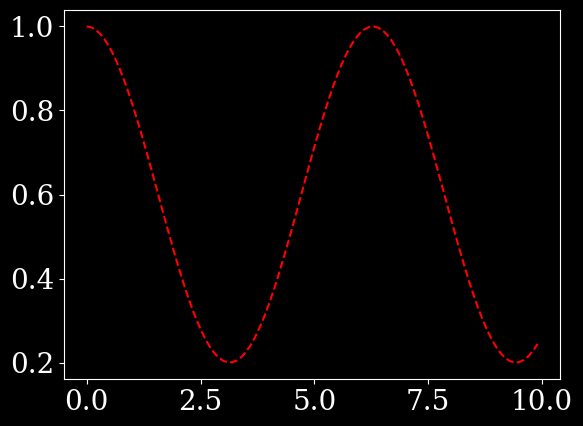

In [ ]:
t = np.arange(0,10, 0.1)
m = (1-0.2)/(1-(-1))
b= 1 - m
x = m*np.cos(t)+b

y0 = x[0]
y1 = x[1]
y = np.zeros(len(t))
y[0] = y0
y[1] = y1
dt = 0.1
for i in range(2, len(t)):
    y2 = y1+ (y1-y0) -dt*dt * y1
    y[i] = y2
    y0 = y1
    y1 = y2

plt.figure()
plt.plot(t,x,'--r')
#plt.plot(t,y,'--b')
plt.show()


In [ ]:

t = np.arange(0,2*np.pi, np.pi/100)
x = np.cos(t)

y0 = x[0]
y1 = x[1]
y = np.zeros(len(t))
y[0] = y0
y[1] = y1
dt = np.pi/100
for i in range(2, len(t)):
    y2 = y1+ (y1-y0)*dt +dt*dt * y1
    y[i] = y2
    y0 = y1
    y1 = y2

plt.figure()
plt.plot(t,x,'r')
plt.plot(t,y,'b')
plt.show()

## Plots

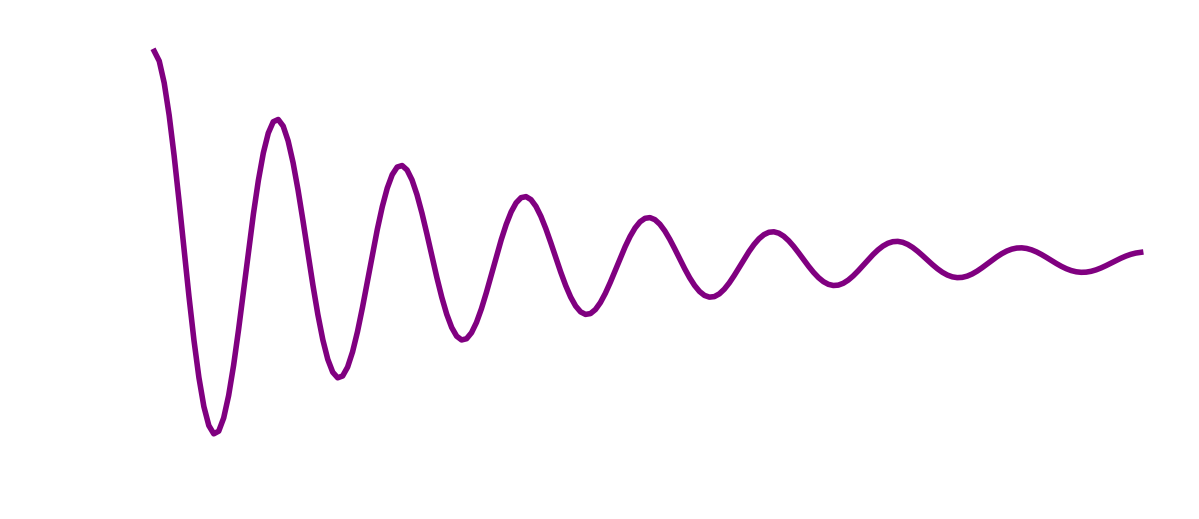

In [ ]:
t = np.arange(0,2*np.pi, np.pi/100)
x = np.exp(-0.5*t)*np.cos(8*t) 

plt.figure(figsize=(14, 6))

plt.plot(t, x, linewidth=4, color='purple')


plt.ylim(-1, 1.2)
plt.xticks(fontsize=20)  
plt.yticks(fontsize=20)
plt.rcParams.update({
    'text.color': 'white',     # Font color
    'axes.labelcolor': 'white',# Axis label color
    'xtick.color': 'white',    # X-axis tick color
    'ytick.color': 'white',    # Y-axis tick color
    'axes.edgecolor': 'white'  # Axis edge color
})
plt.grid(False)

# Save the plot with high resolution and no background
plt.savefig('damped_pendulum_plot.png', dpi=300, transparent=True)
plt.show()

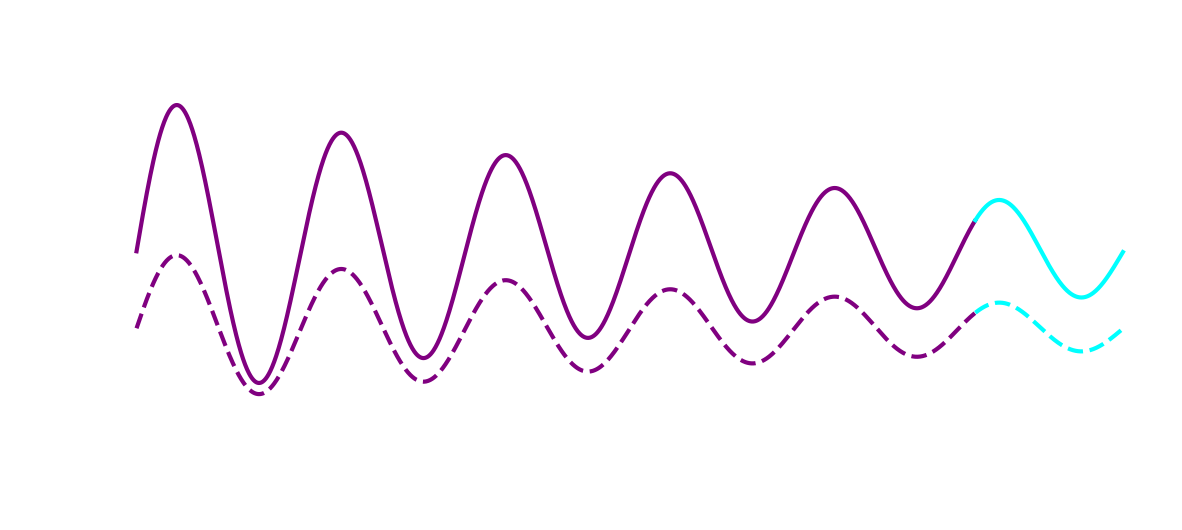

In [ ]:
t = np.arange(0,2*np.pi, np.pi/1000)
x = np.exp(-0.2*t)*np.sin(6*t)
x2 = 0.5*x-0.5


plt.figure(figsize=(14, 6))

testat = 300

plt.plot(t[0:-testat], x[0:-testat], linewidth=3, color='purple')
plt.plot(t[0:-testat], x2[0:-testat], linewidth=3, color='purple', linestyle='--')

plt.plot(t[-testat::], x[-testat::], linewidth=3, color='cyan')
plt.plot(t[-testat::], x2[-testat::], linewidth=3, color='cyan', linestyle='--')


plt.ylim(-1.5, 1.5)
plt.xticks(fontsize=20)  
plt.yticks(fontsize=20)
plt.rcParams.update({
    'text.color': 'white',     # Font color
    'axes.labelcolor': 'white',# Axis label color
    'xtick.color': 'white',    # X-axis tick color
    'ytick.color': 'white',    # Y-axis tick color
    'axes.edgecolor': 'white'  # Axis edge color
})
plt.grid(False)

# Save the plot with high resolution and no background
plt.savefig('damped_pendulum_plot.png', dpi=300, transparent=True)
plt.show()